# FRA503-DRL_HW2

**จัดทำโดย**

1. อนวัช อนุสุเรนทร์ 65340500056 
2. ชัญญาภัค ทรัพย์สวัสดิ์กุล 65340500067

In [2]:
from IPython.display import HTML

## Part 1: Setting up Cart-Pole Agent

In [ ]:
#Set up
import torch
from collections import defaultdict
from enum import Enum
import numpy as np
import os
import json
import torch

class ControlType(Enum):
    MONTE_CARLO = 1
    TEMPORAL_DIFFERENCE = 2
    Q_LEARNING = 3
    DOUBLE_Q_LEARNING = 4

 ### 1. RL Base class

#### 1.1. Discretizes and scales the state based on observation weights.

In [ ]:
def discretize_state(self, obs: dict):
    #1. การกำหนดจำนวนค่าที่ใช้ในการแบ่งช่วง (Bins)
    pose_cart_bin = self.discretize_state_weight[0]
    pose_pole_bin = self.discretize_state_weight[1]
    vel_cart_bin = self.discretize_state_weight[2]
    vel_pole_bin = self.discretize_state_weight[3]
       
    # 2. การกำหนด Boundaries ของค่าต่างๆ*
    pose_cart_bound = 3
    pose_pole_bound = float(np.deg2rad(24.0))
    vel_cart_bound = 15
    vel_pole_bound = 15

    #3. การดึงข้อมูลจาก Observation
    pose_cart_raw, pose_pole_raw , vel_cart_raw , vel_pole_raw = obs['policy'][0, 0] , obs['policy'][0, 1] , obs['policy'][0, 2] , obs['policy'][0, 3]
    
    #4. การคลิปค่าพิกัดให้ไม่เกิน Boundaries
    pose_cart_clip = torch.clip(pose_cart_raw , -pose_cart_bound ,pose_cart_bound)
    pose_pole_clip = torch.clip(pose_pole_raw , -pose_pole_bound ,pose_pole_bound)
    vel_cart_clip = torch.clip(vel_cart_raw , -vel_cart_bound ,vel_cart_bound)
    vel_pole_clip = torch.clip(vel_pole_raw , -vel_pole_bound ,vel_pole_bound)
    device = pose_cart_clip.device

    # 5. สร้าง Grid สำหรับค่าที่ถูก Clip
    pose_cart_grid = torch.linspace(-pose_cart_bound , pose_cart_bound , pose_cart_bin , device=device)
    pose_pole_grid = torch.linspace(-pose_pole_bound , pose_pole_bound , pose_pole_bin , device=device)
    vel_cart_grid = torch.linspace(-vel_cart_bound , vel_cart_bound , vel_cart_bin , device=device)
    vel_pole_grid = torch.linspace(-vel_pole_bound , vel_pole_bound , vel_pole_bin , device=device)

    # 6. แปลงค่า Continuous เป็น Discrete
    pose_cart_dig = torch.bucketize(pose_cart_clip,pose_cart_grid)
    pose_pole_dig = torch.bucketize(pose_pole_clip,pose_pole_grid)
    vel_cart_dig = torch.bucketize(vel_cart_clip,vel_cart_grid)
    vel_pose_dig = torch.bucketize(vel_pole_clip,vel_pole_grid)

    return ( int(pose_cart_dig), int(pose_pole_dig), int(vel_cart_dig),  int(vel_pose_dig))


**อธิบายหลักการของโค้ด**

ฟังก์ชัน discretize_state มีหน้าที่ในการแปลงค่าจาก observation ที่เป็นค่า continuous ให้อยู่ในรูปแบบของ ค่า discrete หรือ index ซึ่งสามารถนำไปใช้งานกับ Q-table ได้

**ลำดับการทำงาน**
1.กำหนดจำนวนช่วง (bins)

กำหนดจำนวนระดับ (หรือ resolution) สำหรับแต่ละมิติของสถานะ เช่น ตำแหน่งรถ, มุมเสา, ความเร็ว

2.กำหนดขอบเขตของค่าที่ยอมรับได้ (boundaries)

ระบุค่าต่ำสุดและสูงสุดที่เราจะใช้ ซึ่งอ้างอิงจากไฟล์ "CartPole_4.2.0\exts\CartPole\CartPole\tasks\cartpole\stabilize_cartpole_env_cfg.py" เช่น
- ตำแหน่งรถไม่เกิน ±3
- มุมเสาไม่เกิน ±24 องศา (แปลงเป็นเรเดียน)

3.ดึงค่าจาก observation ที่รับมาจาก environment

ได้แก่ตำแหน่งและความเร็วของรถ + มุมและความเร็วของเสา

4.คลิป (clip) ตัดค่าที่เกินขอบเขต เพื่อให้ไม่มีค่าใดเกินขอบเขตที่เราสนใจและป้องกันไม่ให้เกิด index error

5.สร้าง grid (ช่วงของค่า)

ใช้ torch.linspace() เพื่อแบ่งช่วงค่าจากขอบล่างถึงขอบบน เป็นจำนวน bins ที่กำหนดไว้

6.แปลงค่าต่อเนื่องให้เป็นค่า discrete

ใช้ torch.bucketize() เพื่อหาว่าแต่ละค่าที่ถูก clip ตกอยู่ในช่วงไหนของ grid → ได้ผลลัพธ์เป็น index เป็น Discrete

#### 1.2.Select an action using an epsilon-greedy policy

In [ ]:
def get_discretize_action(self, obs_dis) -> int:
    if self.control_type == ControlType.DOUBLE_Q_LEARNING:
        #1.สำรวจ (exploration) เลือก action แบบสุ่ม ด้วยความน่าจะเป็น epsilon
        if torch.rand(1).item() < self.epsilon:
            return torch.randint(0, self.num_of_action, (1,)).item()
        
        #2.ใช้ค่าจาก Q-table ทั้งสองชุด (Double Q-Learning) เพื่อเลือก action
        else:
            qa_numpy = np.array(self.qa_values[obs_dis], dtype=np.float32)
            qb_numpy = np.array(self.qb_values[obs_dis], dtype=np.float32)

            #3.แปลงเป็น PyTorch tensor
            qa_tensor = torch.from_numpy(qa_numpy)
            qb_tensor = torch.from_numpy(qb_numpy)

            #4.หาค่า action ที่ดีที่สุดจากแต่ละ Q-table
            action_from_q1 = torch.argmax(qa_tensor).item()
            action_from_q2 = torch.argmax(qb_tensor).item()

            #5.เลือก action ที่มี Q-value สูงกว่าระหว่าง Q1 และ Q2
            best_action = action_from_q1 if qa_tensor[action_from_q1] >= qb_tensor[action_from_q2] else action_from_q2

            #6.ตรวจสอบให้แน่ใจว่า index อยู่ในช่วงที่ถูกต้อง
            action_idx = max(0, min(best_action, self.num_of_action - 1))
            return int(action_idx)

    else:
        #7.Q-Learning ปกติ (หรือ SARSA) ด้วยนโยบาย epsilon-greedy
        if torch.rand(1).item() < self.epsilon:
            return torch.randint(0, self.num_of_action, (1,)).item()  # สำรวจ (explore)
        else:
            #8.แปลง q_values เป็น tensor ก่อนหา argmax
            self.q_values[obs_dis] = torch.tensor(self.q_values[obs_dis], dtype=torch.float32)
            return int(torch.argmax(self.q_values[obs_dis]).item())  # ใช้ความรู้เดิม (exploit)


**อธิบายหลักการของโค้ด**

ฟังชั่น get_discretize_action เลือก action index ที่ดีที่สุดจาก Q-table (หรือสุ่ม) ด้วย epsilon-greedy
- ถ้า epsilon สูง → มีโอกาสเลือก action แบบสุ่ม (exploration)

- ถ้า epsilon ต่ำ → จะเลือก action ที่ดีที่สุดจาก Q-table (exploitation)

ในกรณี Double Q-Learning จะใช้ Q-table สองชุดในการช่วยกันตัดสินใจเพื่อหลีกเลี่ยง overestimation 

#### 1.3.Maps a discrete action in range [0, n]

In [ ]:
def mapping_action(self, action):
    action_min, action_max = self.action_range
    action_continuous = action_min + (action / (self.num_of_action - 1)) * (action_max - action_min)
    return torch.tensor(action_continuous, dtype=torch.float32)

**อธิบายหลักการของโค้ด**

ฟังก์ชัน mapping_action ใช้สำหรับแปลงค่าของ action index ซึ่งเป็นค่า discrete (เช่น 0, 1, 2, ...) ให้กลายเป็น continuous value ที่สามารถนำไปใช้กับ environment ได้จริง โดย continuous value ที่ได้จะกระจายอยู่ในช่วงที่กำหนดไว้ระหว่าง action_min ถึง action_max ตามจำนวน action ที่มีอยู่ (num_of_action)

**ตัวอย่าง**
action_range = (-1.0, 1.0)
num_of_action = 5
(เริ่มที่ 0 จบที่ 4)
- ถ้า action = 0 → ได้ -1.0
- ถ้า action = 2 → ได้  0.0
- ถ้า action = 4 → ได้  1.0

#### 1.4.Get action based on epsilon-greedy policy

In [ ]:
def get_action(self, obs) -> torch.Tensor:
    #1.แปลง observation ที่ Continuous ให้เป็น discrete
    obs_dis = self.discretize_state(obs)
    #2. เลือก action index ที่ควรทำใน state นั้น
    action_idx = self.get_discretize_action(obs_dis)
    #3. แปลงจาก action index เป็น action จริง
    action_tensor = self.mapping_action(action_idx)
    #4. เพิ่มมิติให้กับ tensor (จาก 1D → 3D) เพื่อให้ตรงกับ input shape ของ environment
    return action_tensor.unsqueeze(0).unsqueeze(0), action_idx 

#### 1.5. Decay epsilon value to reduce exploration over time

ทำการ Decay Epsilon แบบ linear อิงตาม Episode สูงสุดที่ใส่ในไฟล์ train

In [ ]:

def decay_epsilon(self, total_episodes ):
    """
    Decay epsilon value to reduce exploration over time.
    """
    # self.epsilon = max(self.final_epsilon, self.epsilon * (self.epsilon_decay ** episode))
    # self.epsilon = max(self.final_epsilon, self.epsilon * self.epsilon_decay)

    # if total_episodes >
    epsilon_decrease = (1.0 - self.final_epsilon) / total_episodes # Calculate how much to decrease each step
    self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decrease)


#### 1.6. Save the model parameters to a JSON file

In [ ]:
def save_q_value(self, path, filename):
    # 1. แปลง tuple keys เป็น string เนื่องจาก JSON ไม่รองรับการเก็บ tuple
    try:
        q_values_str_keys = {str(k): v.tolist() for k, v in self.q_values.items()}
    except:
        q_values_str_keys = {str(k): v for k, v in self.q_values.items()}

    # 2. ถ้าเป็น Monte Carlo ให้แปลง n_values เป็น string keys และ list
    if self.control_type == ControlType.MONTE_CARLO:
        try:
            n_values_str_keys = {str(k): v.tolist() for k, v in self.n_values.items()}
        except:
            n_values_str_keys = {str(k): v for k, v in self.n_values.items()}

         }
    # 4. สร้าง path สำหรับไฟล์ที่ต้องการบันทึก
    full_path = os.path.join(path, filename)
    # 5. บันทึกข้อมูลโมเดลลงในไฟล์ JSON
    with open(full_path, 'w') as f:
        json.dump(model_params, f)

#### 1.7.Load model parameters from a JSON file

In [ ]:
def load_model(self, path, filename):
    #1.สร้าง path สำหรับไฟล์ที่ต้องการโหลด
    full_path = os.path.join(path, filename)  
    #2.เปิดไฟล์และโหลดข้อมูลจาก JSON      
    with open(full_path, 'r') as file:
        data = json.load(file)
        data_q_values = data['q_values']
        #3.แปลงค่าจาก string เป็น Tuple และเก็บลงใน q_values
        for state, action_values in data_q_values.items():
            state = state.replace('(', '')
            state = state.replace(')', '')
            tuple_state = tuple(map(float, state.split(', ')))
            self.q_values[tuple_state] = action_values.copy()
            #กรณีของ DOUBLE_Q_LEARNING ต้องเก็บ q-value 2 table
            if self.control_type == ControlType.DOUBLE_Q_LEARNING:
                self.qa_values[tuple_state] = action_values.copy()
                self.qb_values[tuple_state] = action_values.copy()
        #กรณีของ Monte carlo ต้องเก็บ n-value ด้วย
        if self.control_type == ControlType.MONTE_CARLO:
            data_n_values = data['n_values']
            for state, n_values in data_n_values.items():
                state = state.replace('(', '')
                state = state.replace(')', '')
                tuple_state = tuple(map(float, state.split(', ')))
                self.n_values[tuple_state] = n_values.copy()
        return self.q_values

**อธิบายหลักการของโค้ด**

ฟังก์ชัน load_model ใช้สำหรับโหลดโมเดลที่ถูกฝึกแล้วจากไฟล์ JSON ซึ่งเก็บข้อมูล Q-values และข้อมูลที่เกี่ยวข้องกับการ Train Agent ฟังก์ชัน load_model จะดึงข้อมูล Q-values สำหรับแต่ละ state-action pair จากไฟล์และแปลง state ที่เก็บเป็น String ที่อยู่ในรูปแบบของ tuple(เช่น "(1.0, 2.0)") ให้เป็น real tuple ที่มีค่าเป็น float และเก็บค่าของ action ที่เกี่ยวข้องใน q_values ของ Agent

- สำหรับ Double Q-learning (DQ) ฟังก์ชันจะโหลด Q-values ทั้งจาก Q_A และ Q_B, ซึ่งเป็นการใช้ สอง Q-tables แยกกันเพื่อเลือก action ที่ดีที่สุดและอัปเดต Q-values โดยลดปัญหา overestimation bias.

- สำหรับ Monte Carlo (MC) ฟังก์ชันจะโหลด n_values ซึ่งใช้เก็บการนับจำนวนครั้งที่ state-action pair ถูก Agent เยี่ยมชม(ถูกเลือกใช้จริง)ระหว่างการฝึก และใช้ข้อมูลนี้ในการคำนวณค่าเฉลี่ยของ Q-values อย่างถูกต้อง เพื่ออัปเดต Q-values ที่ stable และ unbiased

### 2. Algorithm

#### 2.1. Monte Carlo

**แนวคิด**

Monte Carlo เป็นวิธีการเรียนรู้เสริมกำลัง (Reinforcement Learning - RL) ที่อิงกับการใช้ค่า **ประสบการณ์ทั้งหมด(next state ถึง end)ของแต่ละตอน (episode)** เพื่ออัปเดตค่าประมาณของฟังก์ชันค่า (Value Function)

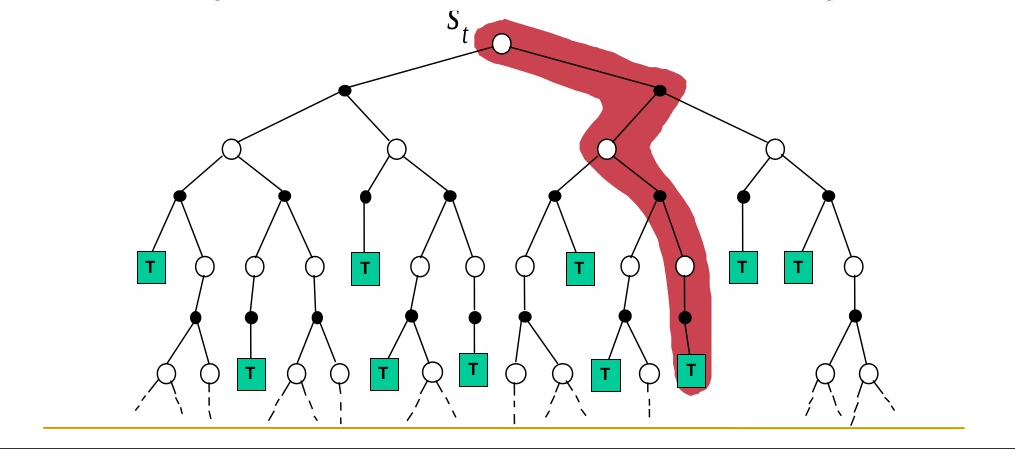

In [ ]:
def update(self):
    """
    Update Q-values using Monte Carlo.
    This method applies the Monte Carlo update rule to improve policy decisions by updating the Q-table.
    """
    return_sum = 0 

    obs_hist_list = [tuple(obs.cpu().numpy()) if isinstance(obs, torch.Tensor) else tuple(obs) for obs in self.obs_hist]
    # update First occur
    for t in reversed(range(len(self.obs_hist))):
        state = self.obs_hist[t]
        action = self.action_hist[t]
        reward = self.reward_hist[t]
        if isinstance(state, dict):
            state = tuple(state.values())  
        if isinstance(state, torch.Tensor):
            state = tuple(state.cpu().numpy()) 
            return_sum = self.discount_factor * return_sum + reward  # Compute return     
        if state not in obs_hist_list[:t]:  # First-visit MC update
            self.n_values[state][action] += 1
            self.q_values[state][action] = ((self.q_values[state][action] * (self.n_values[state][action])) + return_sum) / (self.n_values[state][action] + 1)

**อธิบายโค้ดแยกแต่ละส่วน**

**1. กำหนดโครงสร้างเริ่มต้น**

1. กำหนด return ตั้งต้น

        return_sum = 0

2. ย้อนลูปจาก timestep สุดท้ายไป timestep แรก เพราะต้องการคำนวณ return จากอนาคตมายังปัจจุบัน พร้อมทั้งดึงข้อมูลของ state, action, และ reward ใน timestep t จาก history ของ episode

        for t in reversed(range(len(self.obs_hist))):
                state = self.obs_hist[t]
                action = self.action_hist[t]
                reward = self.reward_hist[t]

**2. การคำนวณค่าผลตอบแทนสะสม (Return)**

ค่าผลตอบแทนสะสมถูกคำนวณย้อนกลับจากตอนจบของ episode
ใช้สูตร Discounted Return เพื่อลดค่าน้ำหนักของ reward ในอนาคต

        return_sum = self.discount_factor * return_sum + reward  


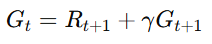   ----กระจายได้เป็น---> 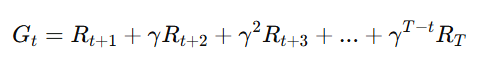
- G_𝑡 >> ค่าผลตอบแทนที่สะสม (Return) ใน timestep t
- 𝑅_𝑡 >> reward ที่ได้รับใน timestep t
- γ >> Discount Factor ที่ใช้ลดค่าของ reward ในอนาคตให้มีน้ำหนักน้อยลง

**3. First-Visit Monte Carlo Condition**

เช็คว่า state นี้ปรากฏเป็นครั้งแรกใน episode หรือไม่

        if state not in self.obs_hist[:t]:

ถ้าใช่
1. Update ค่าจำนวนครั้งที่ state-action นี้ถูกสำรวจ

        self.n_values[state][action] += 1
2. Update ค่า Q-value ของ (state, action)

        self.q_values[state][action] += (return_sum - self.q_values[state][action]) / self.n_values[state][action]


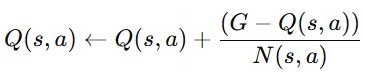

- Q(s,a) >> ค่าประมาณ Q-value ของ state-action ปัจจุบัน
- 𝐺(s,a) >> ค่าผลตอบแทนสะสม return_sum
- N(s,a) >> จำนวนครั้งที่ state-action (s, a) ถูกเข้าถึง

#### 2.2. SARSA class

**หลักการของ SARSA**

SARSA ใช้เพื่อปรับปรุงการตัดสินใจโดยการเรียนรู้จาก action ที่ Agent เลือกจริงๆ ในแต่ state  (ไม่ใช่เลือกแค่ action ที่ดีที่สุดในอนาคต)

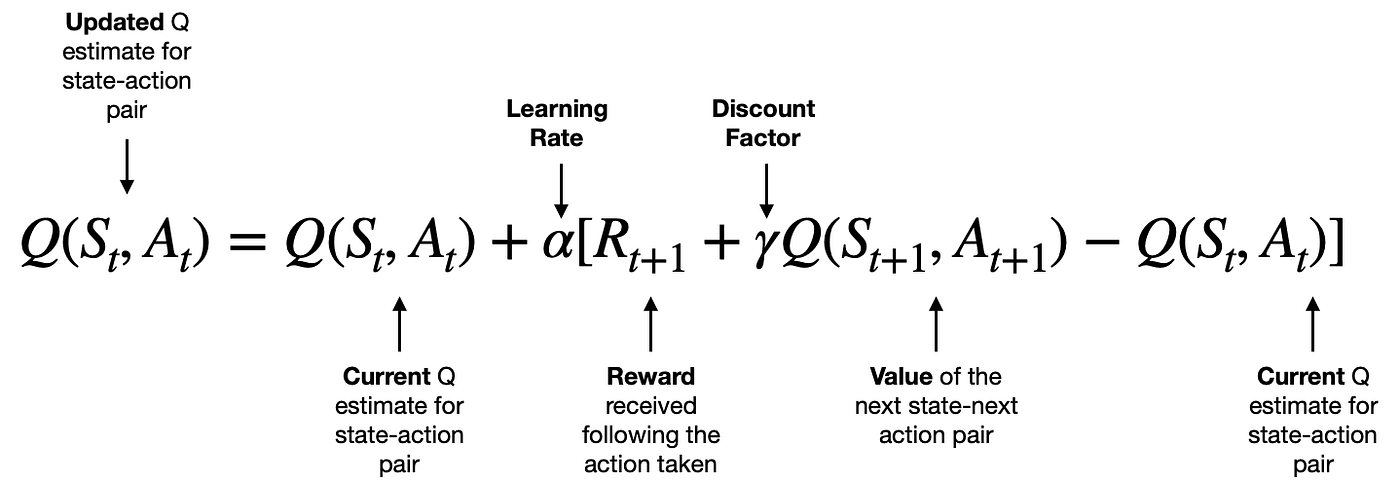

- State (S) >>  คือ State ปัจจุบันที่ Agent อยู่ในตอนนั้น

- Action (A) >> คือ action ที่ Agent เลือกใน State ปัจจุบัน

- Reward (R) >> คือ reward ที่ได้รับหลังจากทำ action ใน state ปัจจุบัน ที่เวลา t

- Next State (S') >>  คือ State ที่ Agent ย้ายไปหลังจากทำ action

- Next Action (A') >> คือ action ที่ Agent ลือกใน state ถัดไป

In [ ]:
def update(self, state, action, reward, next_state, next_action):
        """
        Update Q-values using SARSA.

        This method applies the SARSA update rule to improve policy decisions by updating the Q-table.    
        """
        q_current = self.q_values[state][action]
        q_next = self.q_values[next_state][next_action] if next_state is not None else 0  
        
        self.q_values[state][action] += self.lr * (reward + (self.discount_factor * q_next) - q_current) 

**อธิบายโค้ดแยกแต่ละส่วน**

**1. การคำนวณ Q-value ปัจจุบัน**

        q_current = self.q_values[state][action]

q_current เป็น Q-value ของ action ใน state ปัจจุบัน ซึ่งค่า Q-value นี้จะเก็บการประเมินว่า action ใน state นี้ดีแค่ไหนในแง่ของ reward ที่ Agent คาดว่าจะได้รับ

**2. การคำนวณ Q-value ของ next sate**

        q_next = self.q_values[next_state][next_action] if next_state is not None else 0

q_next คือ Q-value ของ next_state และ next_action ถ้าหาก next_state ไม่ใช่ None แต่ถ้า next_state คือ None หมายถึงเราอยู่ในสถานะสุดท้ายแล้ว ค่าของ q_next จะเป็น 0

**3. การอัปเดต Q-value ด้วยกฎของ SARSA**

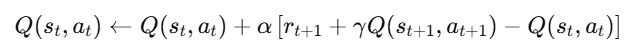

        
        self.q_values[state][action] += self.lr * (reward + (self.discount_factor * q_next) - q_current)
        

อัปเดต Q-value โดยใช้สูตรของ SARSA ซึ่งคำนวณจากค่าผิดพลาดระหว่างค่าที่คาดการณ์ (expected value) และค่าที่ได้รับจริง (real value) เพื่อปรับปรุง Q-value ให้ดีขึ้น


#### 2.3. Q-Learning Class

**หลักการของ Q-Learning**

Q-learning เป็น Off-Policy Reinforcement Learning วิธีที่ช่วยให้ตัวแทนเรียนรู้การเลือก action ที่ดีที่สุดในแต่ละ state โดยการอัปเดต Q-value ซึ่งคือค่าประเมินสำหรับการทำ action ใน state นั้นๆ โดยคำนึงถึง reward ที่ได้รับจากการทำ action และการเลือก action ที่ดีที่สุดใน state ถัดไป

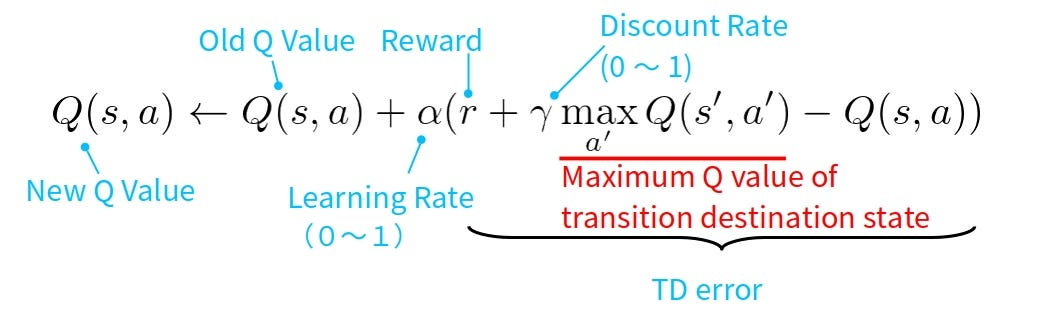

State (S) >> คือ State ปัจจุบันที่ Agent อยู่ในตอนนั้น

Action (A) >> คือ action ที่ Agent เลือกใน State ปัจจุบัน

Reward (R) >> คือ reward ที่ได้รับหลังจากทำ action ใน state ปัจจุบัน ที่เวลา t

Next State (S') >> คือ State ที่ Agent ย้ายไปหลังจากทำ action

Max Action Q-value (max_a Q(s')) >> คือ ค่าของ action ที่ดีที่สุดใน state ถัดไป (เลือก action ที่ให้ Q-value สูงสุดใน state ถัดไป)

In [ ]:
def update(self, state, action, reward, next_state):
        """
        Update Q-values using Q-Learning.

        This method applies the Q-Learning update rule to improve policy decisions by updating the Q-table.
        """
        q_current = self.q_values[state][action] = self.q_values[state][action]
        q_next = 0 if next_state is None else np.max(self.q_values[next_state]) 
        
        self.q_values[state][action] += self.lr * (reward + (self.discount_factor * q_next) - q_current)

**อธิบายโค้ดแยกแต่ละส่วน**

**1. การคำนวณ Q-value ปัจจุบัน**

        q_current = self.q_values[state][action]

q_current เป็น Q-value ของ action ใน state ปัจจุบัน ซึ่งค่า Q-value นี้จะเก็บการประเมินว่า action ใน state นี้ดีแค่ไหนในแง่ของ reward ที่ Agent คาดว่าจะได้รับ

**2. การคำนวณ Q-value ที่ดีที่สุดของ next sate**

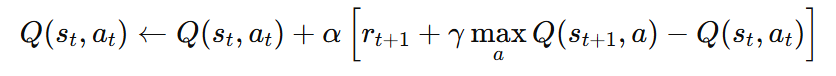

        q_next = 0 if next_state is None else np.max(self.q_values[next_state]) 

q_next คือ ค่าที่ดีที่สุดใน Q-table ของ next_state , ได้จากการใช้ np.max(self.q_values[next_state]) เพื่อเลือก action ที่ดีที่สุดใน state นั้น

**3. การอัปเดต Q-value ด้วยกฎของ Q-Learning**

        self.q_values[state][action] += self.lr * (reward + (self.discount_factor * q_next) - q_current)

อัปเดต Q-value โดยใช้ค่าที่ดีที่สุดใน Q-table ของ next_state ซึ่งคำนวณจากค่าผิดพลาดระหว่างค่าที่คาดการณ์ (expected value) และค่าที่ได้รับจริง (real value) เพื่อปรับปรุง Q-value ให้ดีขึ้น

#### 2.4. Double Q-Learning Class

**หลักการของ Double Q-learning**

Double Q-learning (DQ) คือการขยายจาก Q-learning ที่มีจุดประสงค์หลักเพื่อแก้ไขปัญหาของ overestimation bias ในการประเมิน Q-values ของการกระทำในแต่ละสถานะ (state-action values) โดยการใช้ สอง Q-tables (Q_A และ Q_B) แทนการใช้ Q-table เดียวเหมือนใน Q-learning ปกติ มีหลักการคิดคือ

**อัปเดต Q-value โดยใช้การเลือก action ที่ดีที่สุดจากหนึ่ง Q-table และใช้อีก Q-table ในการประเมิน Q-value ของ action ที่เลือก**


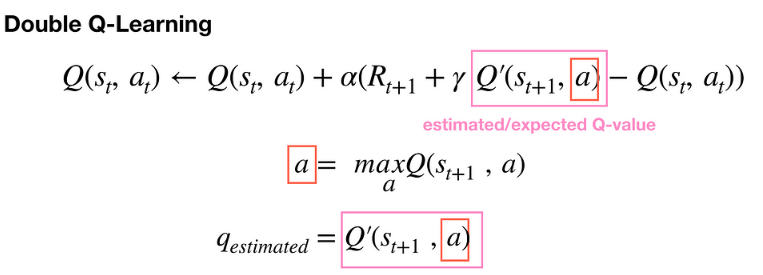

State (S) >> คือ State ปัจจุบันที่ Agent อยู่ในตอนนั้น

Action (A) >> คือ action ที่ Agent เลือกใน State ปัจจุบัน

Reward (R) >> คือ reward ที่ได้รับหลังจากทำ action ใน state ปัจจุบันที่เวลา t

Next State (S') >> คือ State ที่ Agent ย้ายไปหลังจากทำ action

Max Action Q-value (max_a Q(s')) >> คือ ค่าของ action ที่ดีที่สุดใน state ถัดไป (เลือก action ที่ให้ Q-value สูงสุดใน state ถัดไป) โดยใช้ Q_A หรือ Q_B เพื่อเลือก action ที่ดีที่สุดจากสอง Q-tables

In [ ]:
def update(self, state, action, reward, next_state):
    if next_state not in self.qa_values:
        self.qa_values[next_state] = np.zeros(self.num_of_action)
    if next_state not in self.qb_values:
        self.qb_values[next_state] = np.zeros(self.num_of_action)

    if np.random.rand() < 0.5:
        # Update Q_A using Q_B
        best_next_action = np.argmax(self.qa_values[next_state])
        q_next = 0 if next_state is None else self.qb_values[next_state][best_next_action]
        self.qa_values[state][action] += self.lr * (reward + self.discount_factor * q_next - self.qa_values[state][action])
    else:
        # Update Q_B using Q_A
        best_next_action = np.argmax(self.qb_values[next_state])
        q_next = 0 if next_state is None else self.qa_values[next_state][best_next_action]
        self.qb_values[state][action] += self.lr * (reward + self.discount_factor * q_next - self.qb_values[state][action])
        
    #อัปเดตค่า Q-Table 
    self.q_values[state] = (self.qa_values[state] + self.qb_values[state]) / 2

**อธิบายโค้ดแยกแต่ละส่วน**

**1. การตรวจสอบว่า next_state มีการบันทึก Q-values หรือไม่**

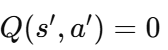

ถ้า next_state ยังไม่มีการบันทึก Q-value ใน Q-tables (ทั้ง Q_A และ Q_B), เราจะสร้างค่าเริ่มต้นเป็น 0 สำหรับ Q_A และ Q_B (จำนวน action ตามที่กำหนด) 

    if next_state not in self.qa_values:
        self.qa_values[next_state] = np.zeros(self.num_of_action)
    if next_state not in self.qb_values:
        self.qb_values[next_state] = np.zeros(self.num_of_action)

**2. การเลือกว่าจะอัปเดต Q_A หรือ Q_B**

    if np.random.rand() < 0.5:
        # Update Q_A using Q_B
        best_next_action = np.argmax(self.qa_values[next_state])
        q_next = self.qb_values[next_state][best_next_action]
        self.qa_values[state][action] += self.lr * (reward + self.discount_factor * q_next - self.qa_values[state][action])
    else:
        # Update Q_B using Q_A
        best_next_action = np.argmax(self.qb_values[next_state])
        q_next = self.qa_values[next_state][best_next_action]
        self.qb_values[state][action] += self.lr * (reward + self.discount_factor * q_next - self.qb_values[state][action])

การใช้ np.random.rand() < 0.5 เพื่อสุ่มว่าจะอัปเดต Q_A หรือ Q_B


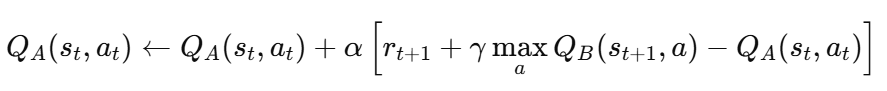


1. ถ้าเงื่อนไขเป็นจริง (เลือกอัปเดต Q_A):

- เลือก action ที่ดีที่สุดใน next_state จาก Q_A (best_next_action = np.argmax(self.qa_values[next_state]))

- นำ Q_B มาใช้ในการคำนวณ q_next ซึ่งเป็น Q-value ของ best_next_action ใน next_state ของ Q_B

- อัปเดต Q_A สำหรับ state และ action ปัจจุบัน โดยใช้ TD error ที่คำนวณจาก reward และ q_next


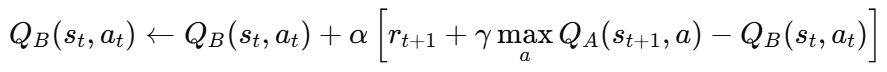


2. ถ้าไม่เป็นจริง (เลือกอัปเดต Q_B):

- เลือก action ที่ดีที่สุดใน next_state จาก Q_B (best_next_action = np.argmax(self.qb_values[next_state]))

- นำ Q_A มาใช้ในการคำนวณ q_next ซึ่งเป็น Q-value ของ best_next_action ใน next_state ของ Q_A

- อัปเดต Q_B สำหรับ state และ action ปัจจุบัน โดยใช้ TD error ที่คำนวณจาก reward และ q_next

**3. การอัปเดต Q-values โดยเฉลี่ยระหว่าง Q_A และ Q_B**

    self.q_values[state] = (self.qa_values[state] + self.qb_values[state]) / 2

คำนวณ Q-value สุดท้ายสำหรับ state ปัจจุบันโดยการเฉลี่ยค่า Q_A และ Q_B ที่อัปเดตแล้ว

## Part 2: Trainning & Playing to stabilize Cart-Pole Agent

###  1. implement the training loop in train script (in the "Can be modified")

In [ ]:
# hyperparameters
num_of_action = 11
action_range = [-16.0 , 16.0] 
discretize_state_weight = [5, 11, 3, 3]  
learning_rate = 0.3
n_episodes = 10000
start_epsilon = 0
epsilon_decay = 0 
final_epsilon = 0
discount = 0.50

**โค้ดทางด้านบนเป็น Parameters ที่เอาไว้ใช้ Initialize Agent รูปแบบต่างๆ ซึ่งประกอบไปด้วย**
1.  num of action - กำหนดการจำนวน bins ที่ใช้ Discrete action_range
2.  action_range - กำหนดช่วงของ action ต่ำสุด-สูงสุด ที่ Agent สามารถเลือกออกมาได้ ซึ่งความละเอียดขึ้นอยู่กับ num_of_action
3.  discretize_state_weight - เป็น Weight ที่เอาไว้ใช้ Discretize Observation ต่างๆ โดยจะมีลำดับดังนี้ [pose_cart:int, pose_pole:int, vel_cart:int, vel_pole:int] [10, 20, 10, 10]
4.  learning rate - อัตรราการเรียนรู้ ซึ่งจะอยู่ในสมการจะเป็น Alpha ที่คูณกับพจน์ของ TD Error ซึ่ง MC ไม่มี
5.  start_epsilon - ค่าเริ่มต้นของ epsilon ที่ใช้ในการทำ epsilon greedy เพื่อเลือก action ขึ้นมา
6.  epsilon_decay - อัตรากาารลดของ epsion ยิ่งใส่น้อย ยิ่งลดเร็วขึ้น
7.  final_epsilon - ค่าสุดท้ายที่ epsilon สามารถลดไปถึงได้
8.  discount - Discount Factor เป็นพจน์ที่คูณอยู่กับ Q-Value ในส่วนของ Algorithm SARSA และจำพวก Q-Learning ส่วน MC จะคูณอยู่กับ Reward

#### 1.1. Monte Carlo

In [ ]:
# reset environment
obs, _ = env.reset()
timestep = 0
sum_reward = 0
sum_count = 0

# simulate environment
while simulation_app.is_running():
    # run everything in inference mode
    with torch.inference_mode():
        for episode in tqdm(range(n_episodes)):
            obs, _ = env.reset()
            done = False
            cumulative_reward = 0
            count = 0

            agent.obs_hist = []
            agent.action_hist = []
            agent.reward_hist = []

            while not done:
                # agent stepping
                action, action_idx = agent.get_action(obs)

                next_obs, reward, terminated, truncated, _ = env.step(action)

                reward_value = reward.item()
                terminated_value = terminated.item() 
                cumulative_reward += reward_value

                agent.obs_hist.append(agent.discretize_state(obs))
                agent.action_hist.append(action_idx)
                agent.reward_hist.append(reward_value)

                count += 1
                    
                done = terminated or truncated
                obs = next_obs

            agent.update()  #edit here
            sum_reward += cumulative_reward
            sum_count += count

            if episode % 100 == 0:
                sum_reward = 0
                sum_count = 0        
                # Save MC agent
                q_value_file = f"{Algorithm_name}_{episode}_{num_of_action}_{action_range[1]}_{discretize_state_weight[0]}_{discretize_state_weight[1]}_{discount}_{learning_rate}.json"
                full_path = os.path.join(f"q_value/{task_name}", Algorithm_name)
                agent.save_q_value(full_path, q_value_file)
                    
            agent.decay_epsilon(n_episodes)
                   
    if args_cli.video:
        timestep += 1
        # Exit the play loop after recording one video
        if timestep == args_cli.video_length:
            break 
    print("!!! Training is complete !!!")
    break

โค้ดทางบนก็จะเป็น main หลักที่ใช้ในการรันโด้ดเพื่อใช้ในการ Simulation และ Training โดยเริ่มจาก ทำการ reset ตัวแปร และ Environment

In [ ]:
obs, _ = env.reset()
timestep = 0
sum_reward = 0
sum_count = 0

จากนั้นก็จะเข้า while เพื่อใช้ในการเช็คว่า Simulation นั้นยังทำงานอยู่ "while simulation_app.is_running():" 

โดยภายใต้ Loop นี้ก็จะมี "torch.inference_mode():" ซึ่งเอาไว้ปิดการคำนวณ Gradient เพื่อใช้ในการปรับปรุง Parameter ในการทำนาย

จากนั้นก็จะเป็น Loop ที่เอาไว้ใช้รันตามขนาดของ episode ที่ได้ตั้งไว้ ซึ่งในแต่ละรอบที่ขึ้น Episode ใหม่ก็จะทำการ reset Environment และได้เป็น Observation มา

ทำการ reset boolean done ให้เป็น False และ reset ตัวแปรต่างๆซึ่งประกอบไปด้วย

cumulative_reward - ใช้ในการบวกรางวัลในแต่ละ Episode

count - ใช้นับเวลาที่ Agent อยู่ใน Episode นั้นๆ

ส่วนตรงนี้ก็จะเป็นการ reset histogram ที่ใช้เพื่อนำไปคำนวณใน Algorithm Monte Carlo ประกอบไปด้วย observation, action และ reward

agent.obs_hist = []

agent.action_hist = []

agent.reward_hist = []

In [ ]:
for episode in tqdm(range(n_episodes)):
    obs, _ = env.reset()
    done = False
    cumulative_reward = 0
    count = 0

    agent.obs_hist = []
    agent.action_hist = []
    agent.reward_hist = []

ส่วน loop ถัดมาก็จะเป็นการรันใน episode นั้นๆ โดยเริ่มจากทำการ get_action หลังจากทำการ Observe Environment เข้ามา โดยจะได้มาเป็น action กับ action's index

จากนั้นก็ทำการ จะทำการรับ observation ใหม่ (next_obs), รางวัล (reward), Boolean ที่บอกว่า epsisode นี้ terminate หรือยัง (terminated) และ Boolean ที่บอกว่า Episode นี้ถูกตัดออกหรือไม่ (truncated)

หลังจากนั้นก็จะนำข้อมูลต่างๆ append ใส่ histogram ที่ตั้งไว้ก่อนหน้านี้ โดย Observation จะมีการทำ Discretize ก่อนเพื่อแปลงจาก Continuous

และก็เพิ่ม count ของ epsiode ขึ้นมา 1 และเช็คว่า terminated หรือ truncated หรือยัง และทำการให้ next_obs = obs และ loop วนไปเรื่อยๆจนจบ Episode 

แล้วเมื่อจบ Episode จึงให้ agent ทำการ update ข้อมูลตามวิธีกการของ Monte Carlo

In [ ]:
while not done:
    # agent stepping
    action, action_idx = agent.get_action(obs)

    next_obs, reward, terminated, truncated, _ = env.step(action)

    reward_value = reward.item()
    terminated_value = terminated.item() 
    cumulative_reward += reward_value

    agent.obs_hist.append(agent.discretize_state(obs))
    agent.action_hist.append(action_idx)
    agent.reward_hist.append(reward_value)

    count += 1
                    
    done = terminated or truncated
    obs = next_obs

agent.update()  #edit here
sum_reward += cumulative_reward
sum_count += count

#### 1.2. SARSA

In [ ]:
# reset environment
obs, _ = env.reset()
print('obs :',obs)
timestep = 0
sum_reward = 0
sum_count = 0
# simulate environment
while simulation_app.is_running():
    # run everything in inference mode
    with torch.inference_mode():
        for episode in tqdm(range(n_episodes),desc="Processing",leave=False,dynamic_ncols=True):
            obs, _ = env.reset()
            done = False
            cumulative_reward = 0
            count = 0
                
            while not done:
                state = agent.discretize_state(obs)
                # agent stepping
                action, action_idx = agent.get_action(obs) #bro
                # env stepping
                next_obs, reward, terminated, truncated, _ = env.step(action) #bro

                next_state = agent.discretize_state(next_obs)
                next_action_idx =agent.get_discretize_action(next_state)

                reward_value = reward.item()#bro
                terminated_value = terminated.item() #bro                  
                cumulative_reward += reward_value#bro
                    
                # editable agent update
                agent.update(state, action_idx, reward_value, next_state,  next_action_idx)  #edit here
                    
                count +=1
                    
                done = terminated or truncated#bro
                obs = next_obs#bro
                
                sum_count += count
                sum_reward += cumulative_reward

            if episode % 100 == 0:
                sum_reward = 0
                sum_count = 0 
                # Save SARSA agent
                q_value_file = f"{Algorithm_name}_{episode}_{num_of_action}_{action_range[1]}_{discretize_state_weight[0]}_{discretize_state_weight[1]}_{discount}_{learning_rate}.json"
                full_path = os.path.join(f"q_value/{task_name}", Algorithm_name)
                agent.save_q_value(full_path, q_value_file)
            agent.decay_epsilon(n_episodes)   
    if args_cli.video:
        timestep += 1
        # Exit the play loop after recording one video
        if timestep == args_cli.video_length:
            break
    print("!!! Training is complete !!!")
    break

##### 3. Q-Learning

In [ ]:
# reset environment
    obs, _ = env.reset()
    timestep = 0
    sum_reward = 0
    sum_count = 0
    # simulate environment
    while simulation_app.is_running():
        # run everything in inference mode
        with torch.inference_mode():
            for episode in tqdm(range(n_episodes)):
                obs, _ = env.reset()
                done = False
                cumulative_reward = 0
                count = 0
                while not done:
                    state = agent.discretize_state(obs)
                    # agent stepping
                    action, action_idx = agent.get_action(obs)
                    next_obs, reward, terminated, truncated, _ = env.step(action)
                    next_state = agent.discretize_state(next_obs)
                    reward_value = reward.item()
                    terminated_value = terminated.item() 
                    cumulative_reward += reward_value 
                    # editable agent update
                    agent.update(state, action_idx, reward_value, next_state)  #edit here
                    
                    count += 1
                    run.log({"epsilon": agent.epsilon,
                            "Episode": episode})

                    done = terminated or truncated
                    obs = next_obs

                    # print('state :' , state, 'action_idx', action, 'reward :', reward_value,'Next state ',next_state)
                sum_count += count
                sum_reward += cumulative_reward
                if episode % 100 == 0:
                    print("avg_score: ", sum_reward / 100.0)
                    print(agent.epsilon)
                    run.log({"avg_count_per_ep":sum_count / 100.0,
                             "avg_reward":sum_reward / 100.0})
                    
                    sum_reward = 0
                    sum_count = 0
                    
                    # Save Q-Learning agent
                    q_value_file = f"{Algorithm_name}_{episode}_{num_of_action}_{action_range[1]}_{discretize_state_weight[0]}_{discretize_state_weight[1]}_{discount}_{learning_rate}.json"
                    full_path = os.path.join(f"q_value/{task_name}", Algorithm_name)
                    agent.save_q_value(full_path, q_value_file)

                agent.decay_epsilon(n_episodes)
        if args_cli.video:
            timestep += 1
            # Exit the play loop after recording one video
            if timestep == args_cli.video_length:
                break
        
        print("!!! Training is complete !!!")

        break

##### 4. Double Q Learning

In [ ]:
# reset environment
obs, _ = env.reset()
timestep = 0
sum_reward = 0
sum_count = 0
# simulate environment
while simulation_app.is_running():
    # run everything in inference mode
    with torch.inference_mode():
        for episode in tqdm(range(n_episodes)):
            obs, _ = env.reset()
            done = False
            cumulative_reward = 0
            count = 0

            while not done:

                state = agent.discretize_state(obs)
                # agent stepping
                action, action_idx = agent.get_action(obs)
                # env stepping
                next_obs, reward, terminated, truncated, _ = env.step(action)

                next_state = agent.discretize_state(next_obs)

                reward_value = reward.item()
                terminated_value = terminated.item() 
                cumulative_reward += reward_value
                    
                # editable agent update
                agent.update(state, action_idx, reward_value, next_state)  #edit here
                    
                count += 1
                done = terminated or truncated
                obs = next_obs
                
            sum_count += count
            sum_reward += cumulative_reward

            if episode % 100 == 0:
                sum_reward = 0
                sum_count = 0

                # Save DQ-Learning agent
                q_value_file = f"{Algorithm_name}_{episode}_{num_of_action}_{action_range[1]}_{discretize_state_weight[0]}_{discretize_state_weight[1]}_{discount}_{learning_rate}.json"
                full_path = os.path.join(f"q_value/{task_name}", Algorithm_name)
                agent.save_q_value(full_path, q_value_file)

            agent.decay_epsilon(n_episodes)       
    if args_cli.video:
        timestep += 1
        # Exit the play loop after recording one video
        if timestep == args_cli.video_length:
            break 
    print("!!! Training is complete !!!")
    break

ในส่วนของ Algorithm ที่เหลือ (SARSA, Q-Learning, Double-Q-Learning) จะมีการ Update ในระหว่าง episode ไม่เหมือนกับ Monte Carlo 

และทุกไฟล์ในทุกๆ 100 episode จะมีการบันทึก Q-Value เป็น .json และทำกาาร update Epsilon ผ่าน Function .decay_epsilon

**เพิ่มเติมสำหรับการนับ Count ใน loop**

ในส่วนทางผู้จัดทำทำไว้เพื่อใช้ในการจับเวลาว่า Agent อยู่ได้นานเท่าไหร่ ซึ่งในไฟล์Config Agent จะสามารถอยู่ได้ 10 s. ก่อนที่จะ truncated 

In [7]:
    # Post initialization
    def __post_init__(self) -> None:
        """Post initialization."""
        # general settings
        self.decimation = 2
        self.episode_length_s = 10 #second
        # viewer settings
        self.viewer.eye = (8.0, 0.0, 5.0)
        # simulation settings
        self.sim.dt = 0.005
        self.sim.render_interval = self.decimation


### 2. Stabilizing Cart-Pole Experiment

#### 2.1.ทดลองปรับ hyperparameters ที่เกี่ยวข้องกับการเรียนรู้ของ Agent

**Learning Objective**

1. Understand how a reinforcement learning agent learns (i.e., evaluates and improves its policy) in an environment where the true dynamic model is unknown.

2. Gain insight into different reinforcement learning algorithms, including Monte Carlo methods, the SARSA algorithm, Q-learning, and Double Q-learning. Analyze their strengths and weaknesses.

**hyperparameters ที่จะปรับ**
1. Learning rate (learing_rate) : 0.01 0.1 0.3 0.9
2. Discount Factor (discount): 0.1 0.5 0.9
3. Epsilon (epsilon_decay, start_epsilon, final_epsilon)
    - start_epsilon
    - epsilon_decay
    - final_epsilon


**ตัวแปรควบคุม**
- num_of_action = 11

- action_range = [-16.0, 16.0]

- discretize_state_weight = [5, 11, 3, 3]

- n_episodes = num_of_action * discretize_state_weight[0] * discretize_state_weight[1] * discretize_state_weight[2] * discretize_state_weight[3]*2 

**episodes = 10890 เสมอ

##### 1.Learning rate 

**Monte carlo**
- ไม่มี Learning rate ในสมการ


**SARSA**

- เทียบกราฟ Learning rate 0.1 0.3 0.9 กราฟสีชมพู ฟ้า เหลือง ตามลำดับ (discount factor 0.5 )

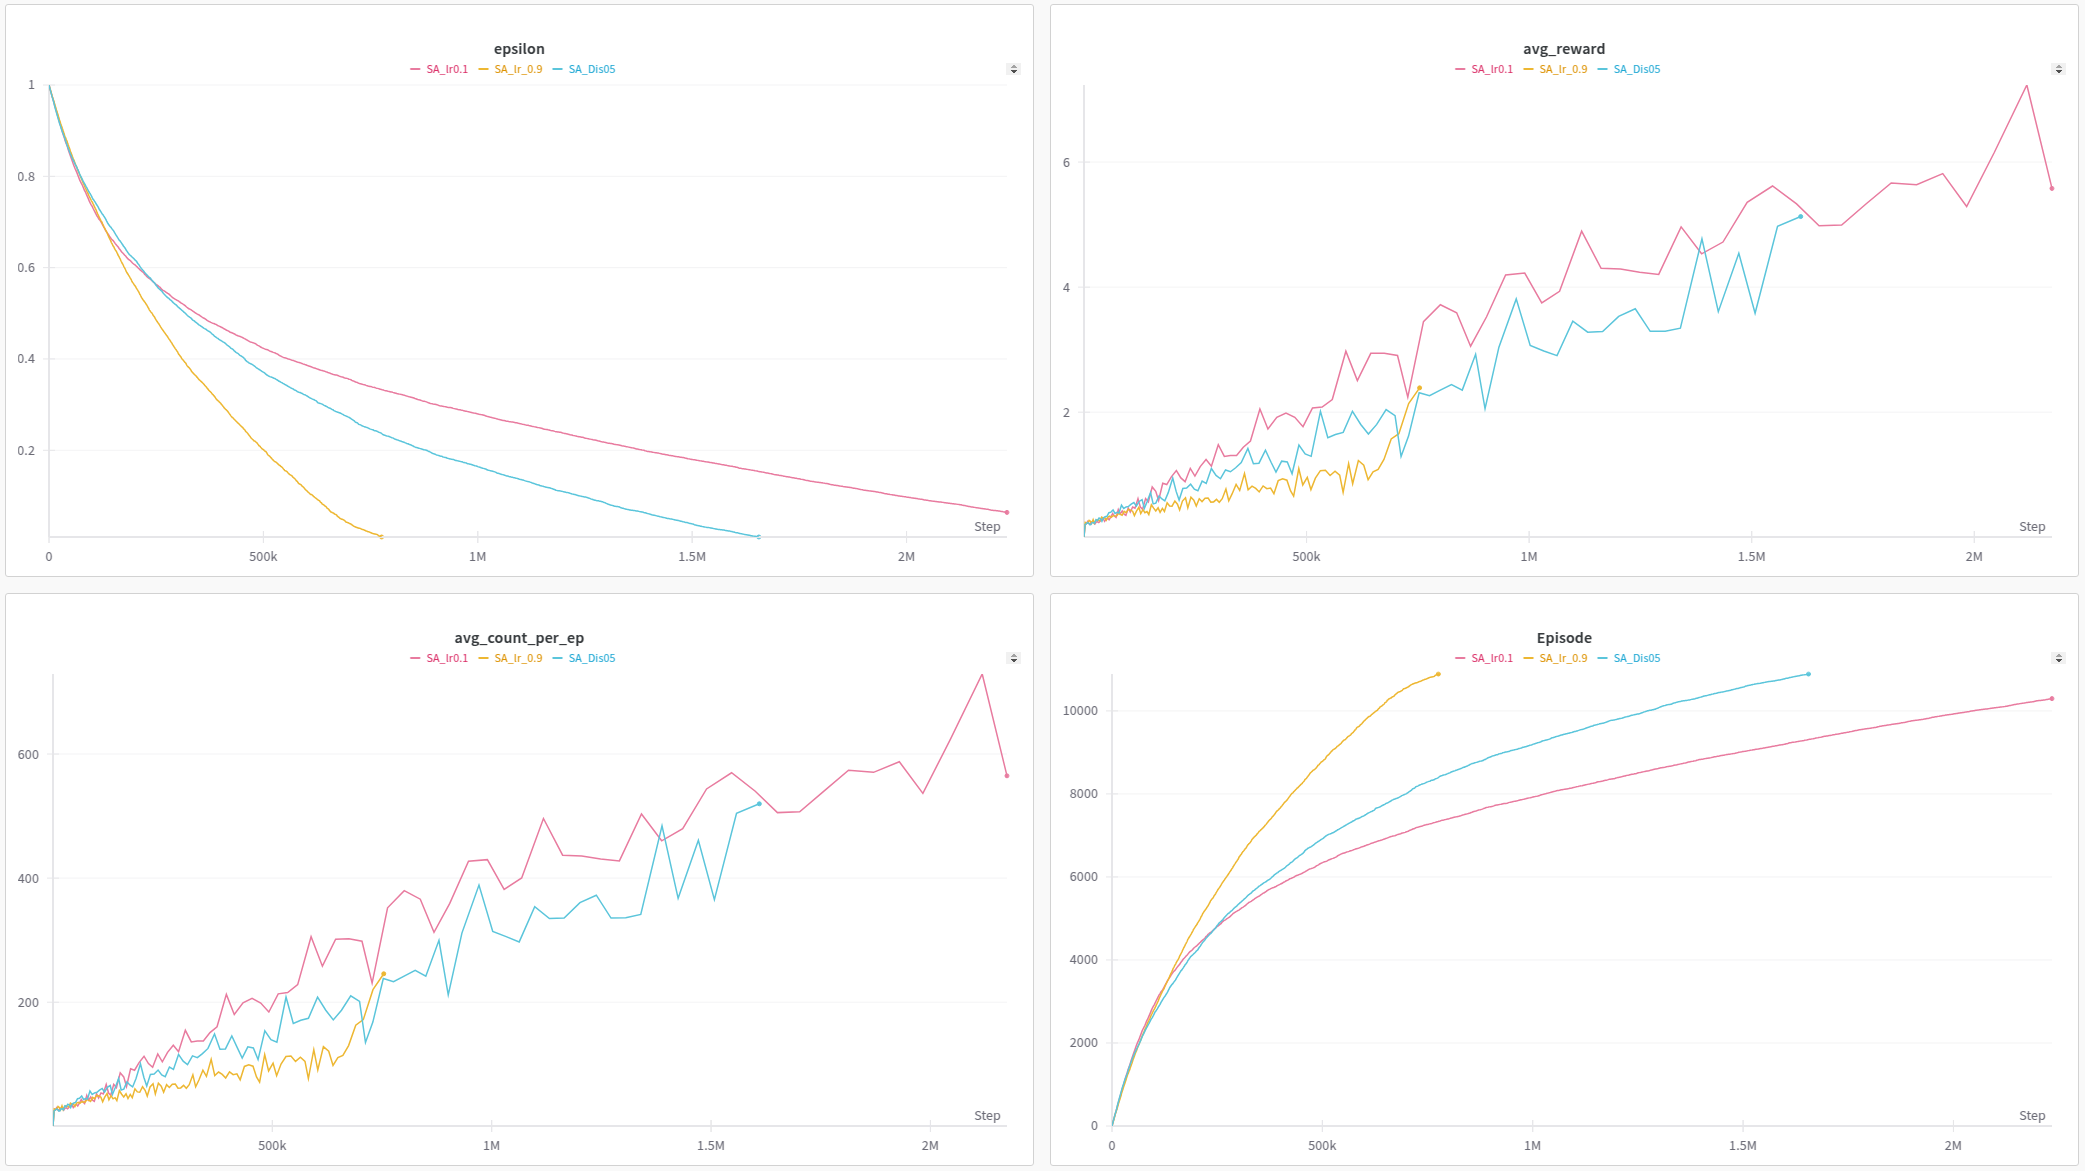

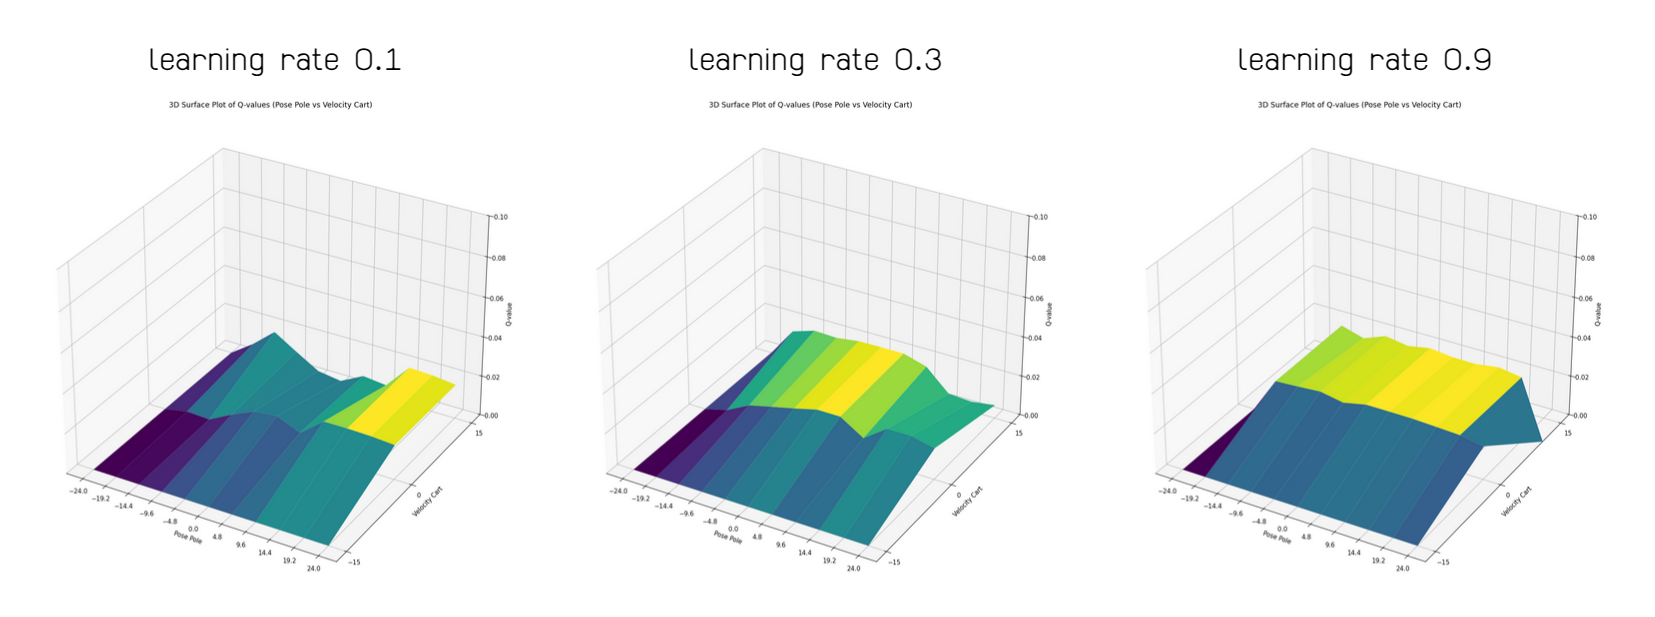

**สรุปผลการทดลอง SARSA**

**0.1 SARSA** ค่อยๆเรียนรู้สำรวจเยอะ ทำให้สามารถเลือก Action ที่ดีขึ้นเรื่อยๆได้ ค่า avg reward เลยสูงที่สุด สังเกตได้จากการสีชมพูจะเพิ่มขึ้นอย่าสเถียรไปเรื่อยๆตามการเรียนรู้ที่มากขึ้นของ Agent

**0.3 SARSA** เรียนรู้ไวขึ้นจาก 0.1 แต่ Exploit ไวขึ้นทำให้ในการ Train ครั้งนี้ Agent ยังไม่สามารถหาค่าที่จะทำให้ได้ avg reward สูงสุด เห็นได้จากกราฟสีฟ้า ที่ในช่วงหลัง reward เพิ่มขึ้นช้า และ Exploit เร็วเกินจะได้ผลลัพธ์ที่ดีที่สุด 

**0.9 SARSA** Exploit ไวมาก ทำให้ไม่สามารถหาค่าที่ดีที่สุดเจอได้ และจบด้วย reward ที่น้อยที่สุด เห็นได้ชัดจากกราฟสีเหลืองที่กราฟจบไวมากเมื่อเทียบกับอีก 2 ค่า แสดงให้เห็นว่าไม่สามารถตั้งเสาได้นาน และไม่ Expolre หาค่าที่ดีกว่าแต่ยึดติดกับค่าเดิมๆ


**Q-learning**

- เทียบกราฟ Learning rate 0.1 0.3 0.9 (discount factor 0.5)

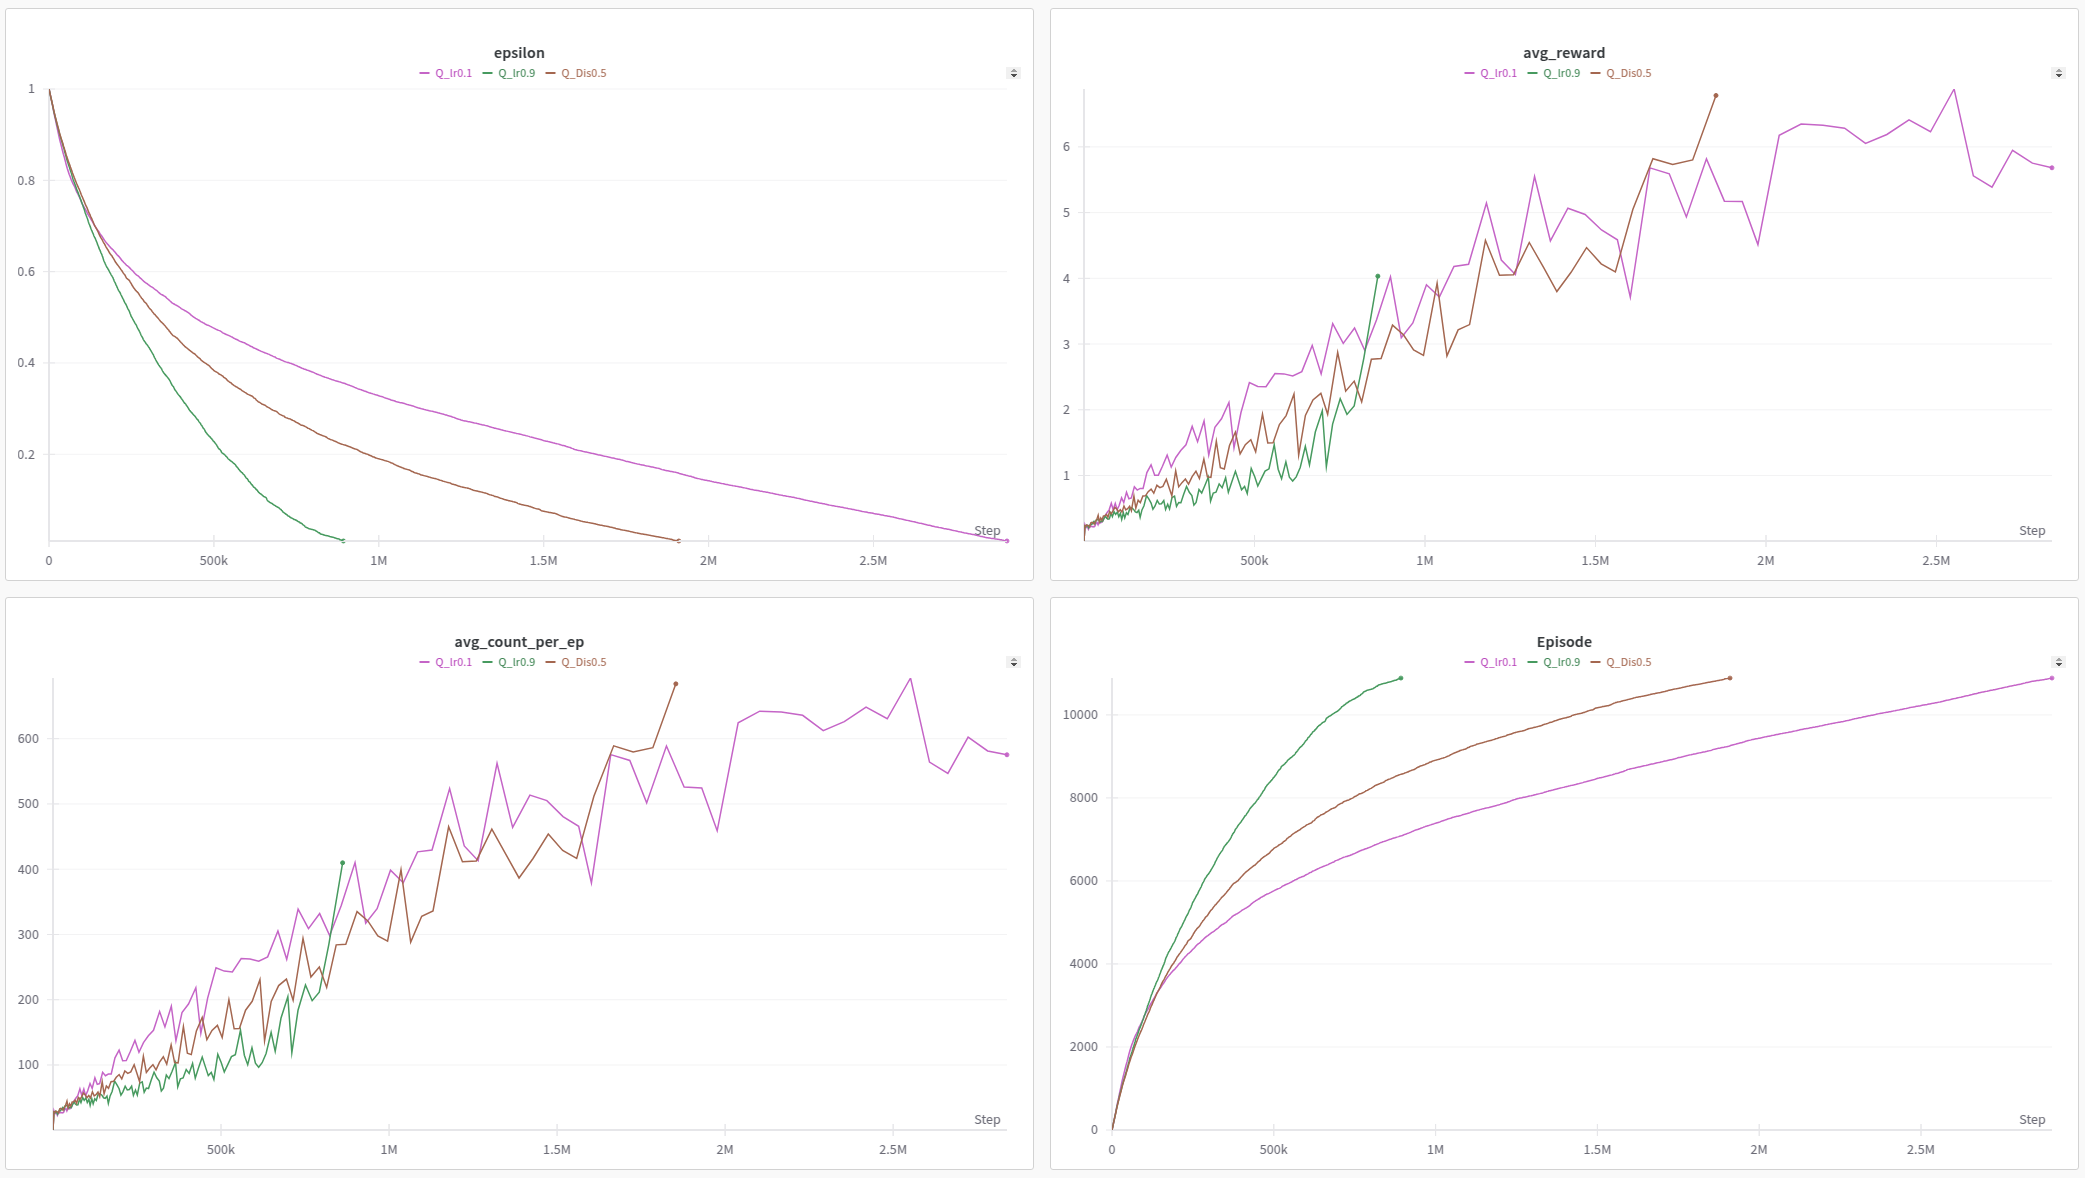

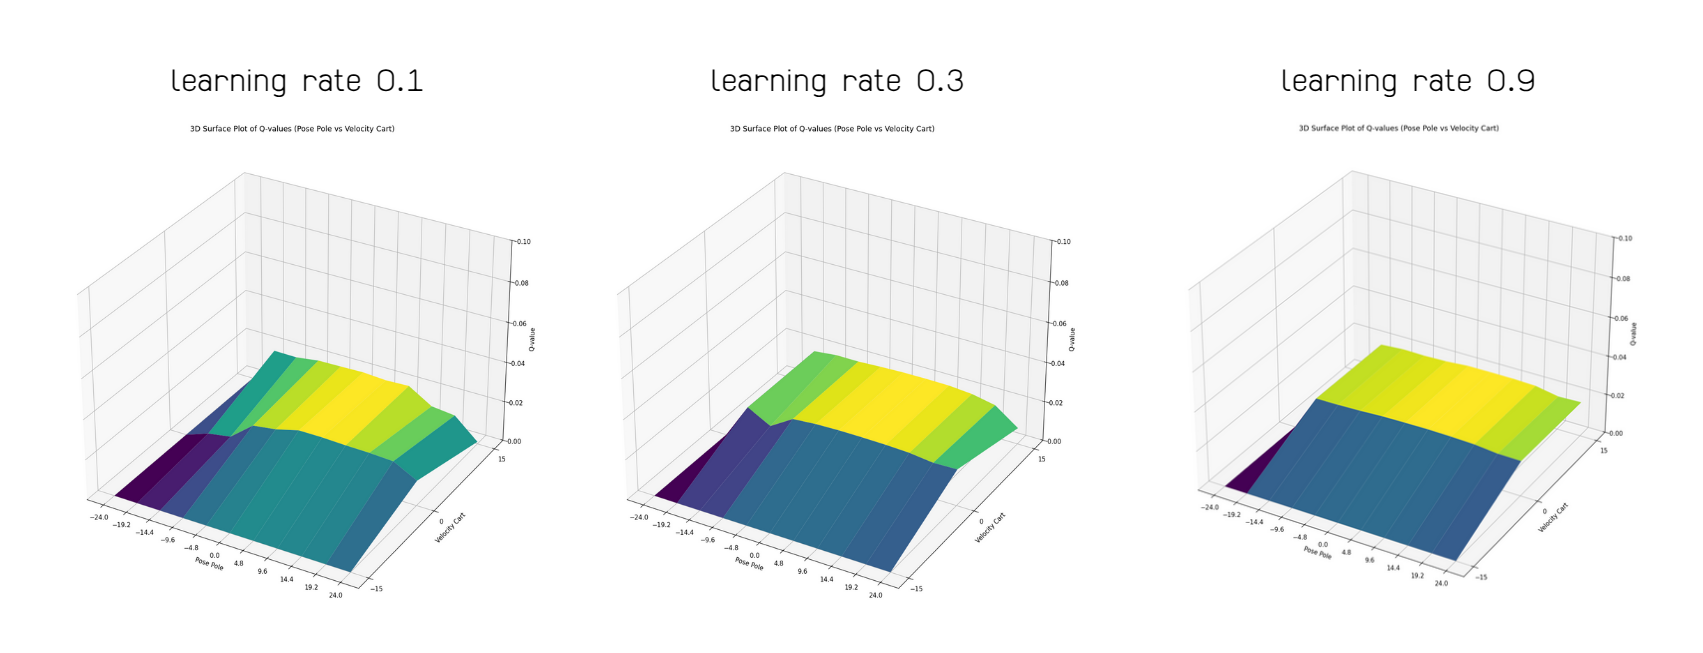

**สรุปผลการทดลอง Q-learning**

**0.1 Q-learning**เริ่มต้น agent explore มาก ทำให้ avg_reward ขึ้นอย่างเสถียรและค่อย ๆ เพิ่มขึ้นตามจำนวนขั้นตอนการฝึก (steps) สังเกตได้จาก epsilon ที่ลดลงช้าและ avg_count_per_ep ที่มีการสำรวจมากในช่วงต้น ผลลัพธ์สุดท้าย reward ค่อนข้างสูงที่สุดเมื่อเทียบกับค่าอื่น ๆ ซึ่งแสดงให้เห็นว่า agent เรียนรู้และปรับตัวได้ดีเมื่อเวลาผ่านไป ถึงแม้การเรียนรู้จะค่อนข้างช้า แต่ agent สามารถหาค่าที่ดีที่สุดได้ในระยะยาว

**0.3 Q-learning** agent เรียนรู้ได้ไวกว่า 0.1 อย่างเห็นได้ชัด เพราะมีการ explore ที่น้อยกว่า learning rate 0.1 แต่อย่างไรก็ตามยังคง explore มากพอที่จะมีโอกาสได้ค่า avg_reward ที่สูงเทียบเท่ากับ learning rate 0.1 แต่ใช้เวลาในการเรียนรู้ที่น้อยกว่า


**0.9 Q-learning** การเรียนรู้ของ agent เร็วมาก แต่ exploit action ที่ดีที่สุดเร็วเกินไป ทำให้ epsilon ลดลงเร็วและ avg_reward ติดที่ระดับต่ำ เนื่องจากไม่สำรวจหาค่าที่ดีกว่า ส่งผลให้ agent ไม่สามารถตั้งเสาได้คงที่และได้รางวัลที่น้อยที่สุดในช่วงท้าย

**Double-Q-learning**

- เทียบกราฟ Learning rate 0.1 0.3 0.9 (discount factor 0.5)

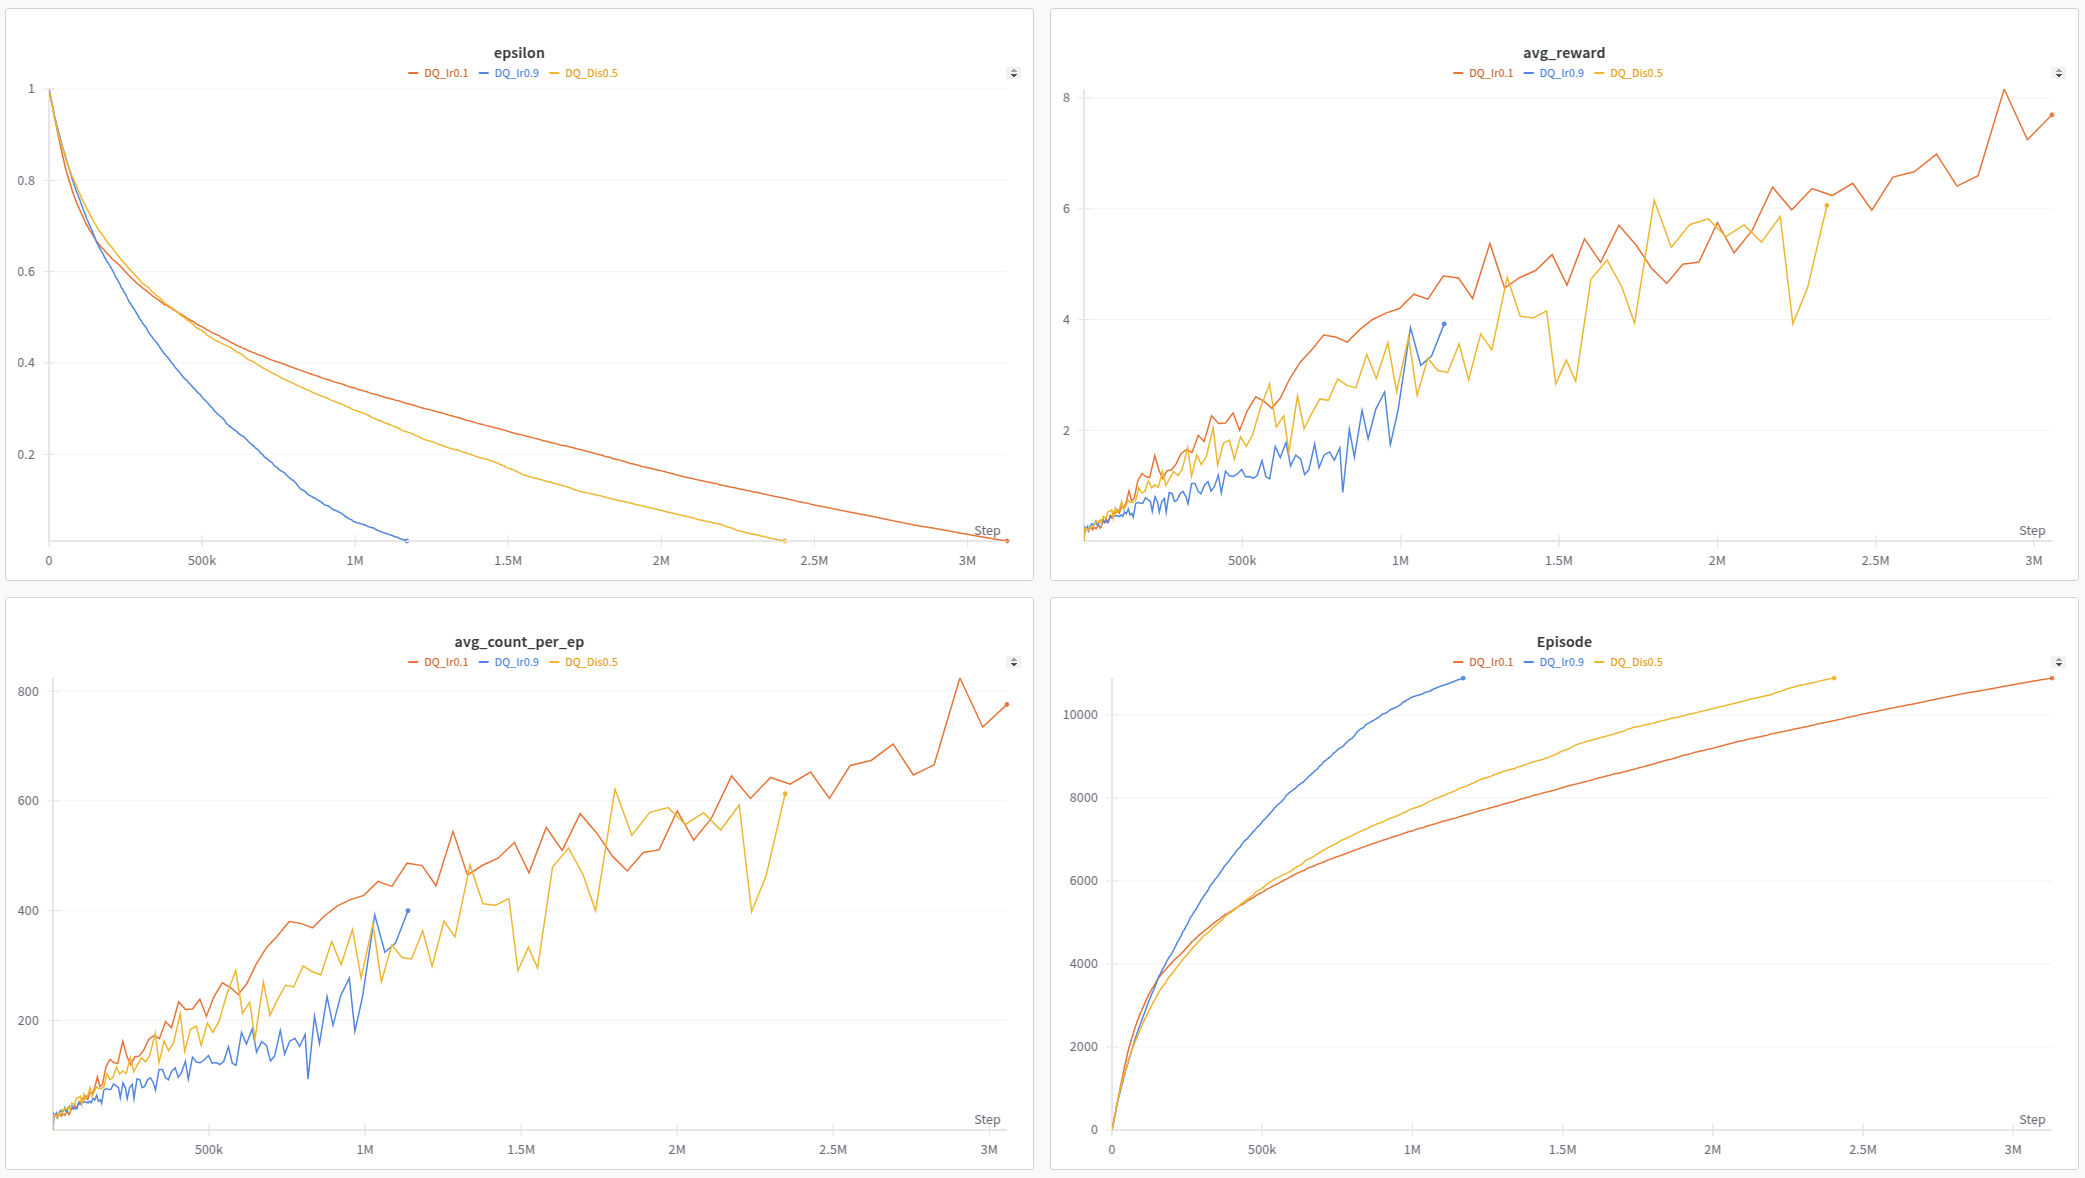

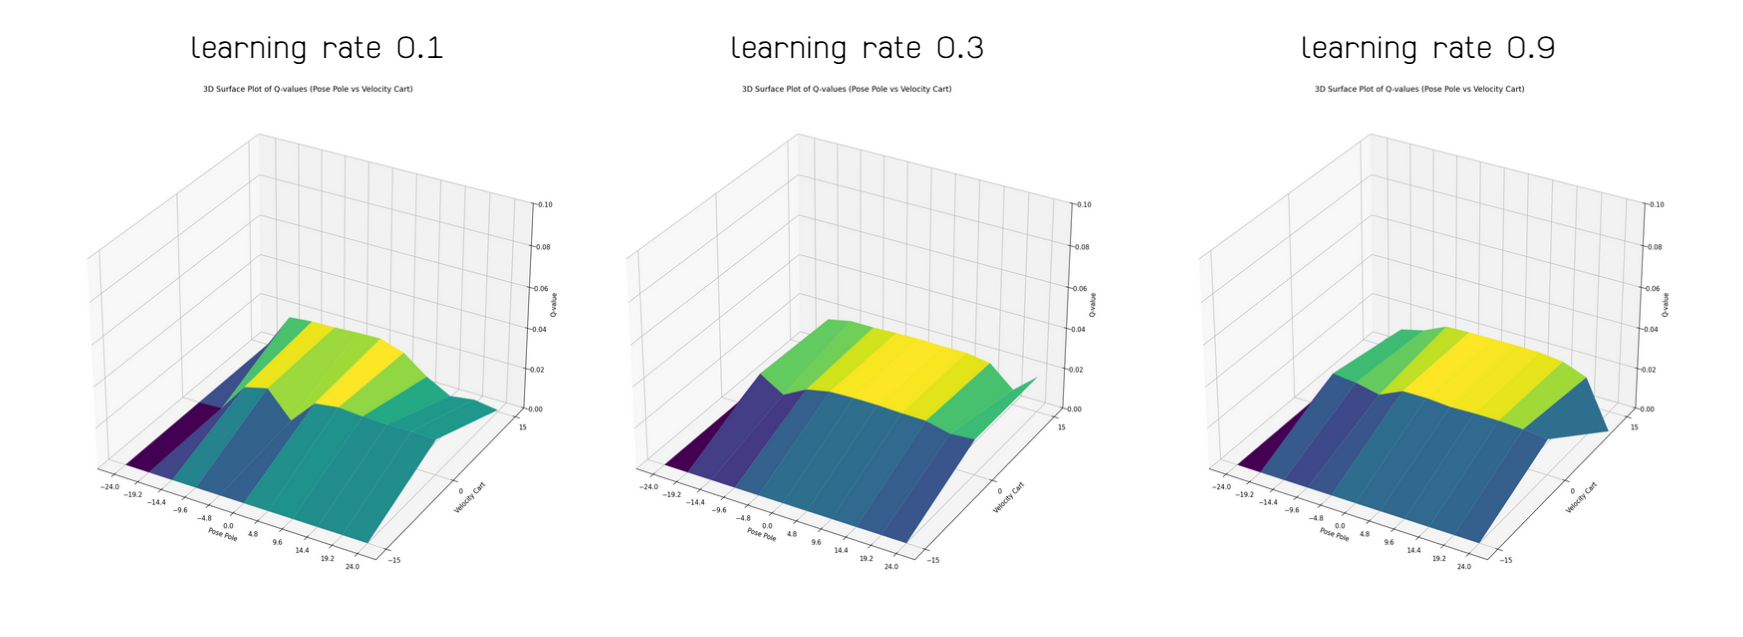

**สรุปผลการทดลอง Double Q Learning**

**0.1 Double Q-learning** เริ่มต้น agent explore มาก ทำให้ avg_reward ขึ้นอย่างเสถียรและค่อย ๆ เพิ่มขึ้นตามจำนวนขั้นตอนการฝึก (steps) สังเกตได้จาก epsilon ที่ลดลงช้าและ avg_count_per_ep ที่มีการสำรวจมากในช่วงต้น และกราฟ 3 มิติที่เป็นหลังคาไม่เรียบเพราะยังคงสำรวจอยู่ ผลลัพธ์สุดท้าย reward ค่อนข้างสูงที่สุดเมื่อเทียบกับค่าอื่น ๆ ซึ่งแสดงให้เห็นว่า agent เรียนรู้และปรับตัวได้ดีเมื่อเวลาผ่านไป ถึงแม้การเรียนรู้จะค่อนข้างช้า แต่ agent สามารถหาค่าที่ดีที่สุดได้ในระยะยาว

**0.3 Double Q-learning** agent เรียนรู้ได้ไวกว่า 0.1 อย่างเห็นได้ชัด เพราะมีการ explore ที่น้อยกว่า แต่ก็ทำให้ค่าของ reward ที่ได้มีความเสถียรน้อยกว่าเพราะ agent เลือกสำรวจน้อยและใช้ค่าที่มั่นใจมากกว่า พอบังเอิญสุ่มเจอ action ที่ reward สูงๆจึงเกิดการแกว่งของ avg_reward  การ Train ครั้งนี้ Agent ยังไม่สามารถหาค่าที่จะทำให้ได้ avg reward สูงสุด ได้สันนิฐานว่าเพราะยัง Explore ไม่เพียงพอที่จะสุ่มเจอค่าที่ดีกว่าจาก Learning rate 0.1



**0.9 Double Q-learning** การเรียนรู้ของ agent เร็วมาก แต่ exploit action ที่ดีที่สุดเร็วเกินไป ทำให้ epsilon ลดลงเร็วและ avg_reward ติดที่ระดับต่ำ เนื่องจากไม่สำรวจหาค่าที่ดีกว่า ส่งผลให้ agent ไม่สามารถตั้งเสาได้คงที่และได้รางวัลที่น้อยที่สุดในช่วงท้าย

**Summary**

##### 2. Discount Factor (discount) 0.1 0.5 0.9

**Monte Calo**

เทียบกราฟ discount factor 0.1 0.5 0.9 (เส้นสี ชมพู ฟ้า เหลือง ตามลำดับ)

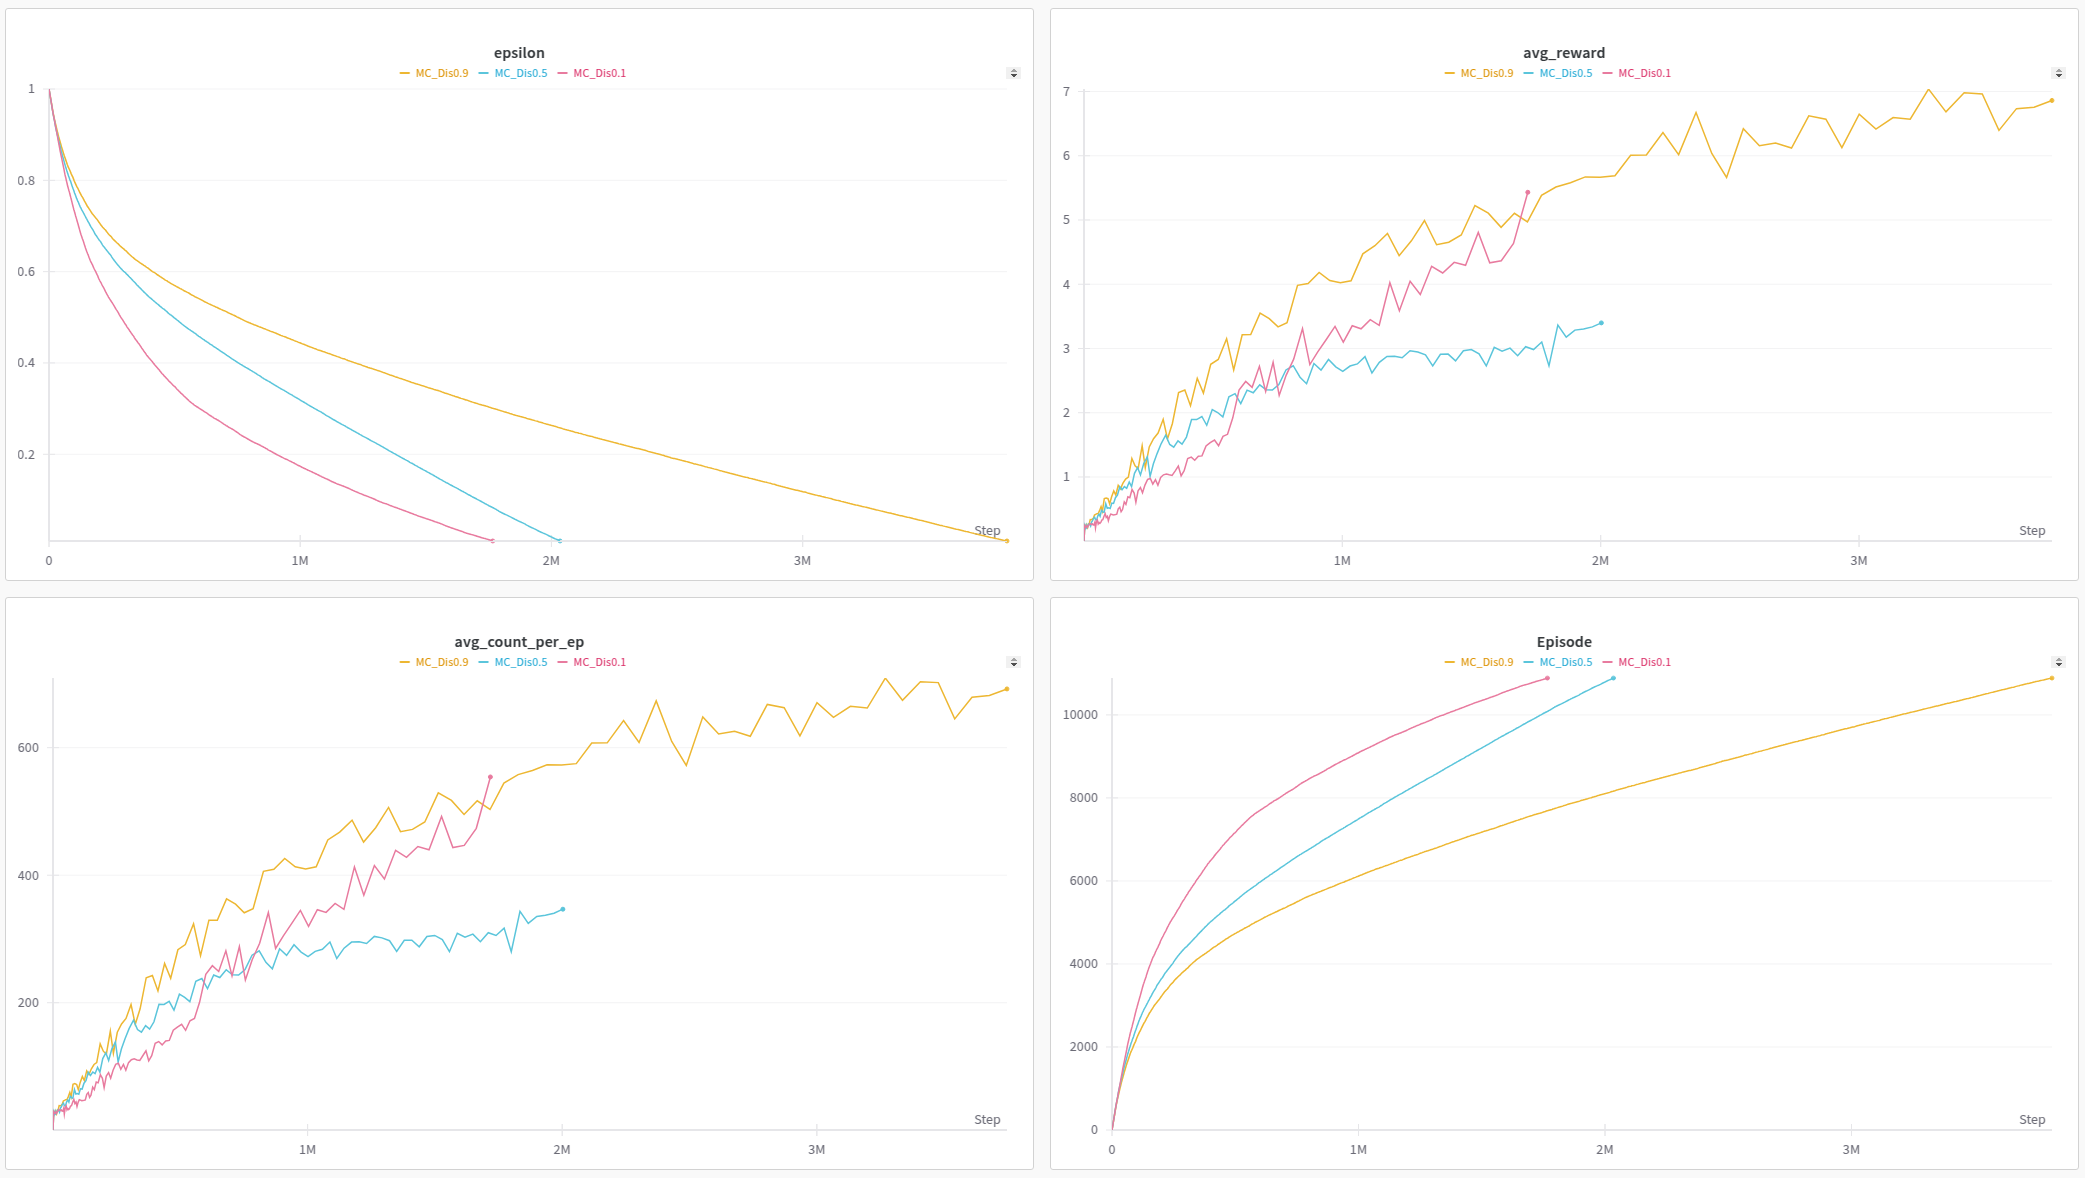

**SARSA**

เทียบกราฟ discount factor 0.1 0.5 0.9 (เส้นสี ชมพู ฟ้า เหลือง ตามลำดับ)

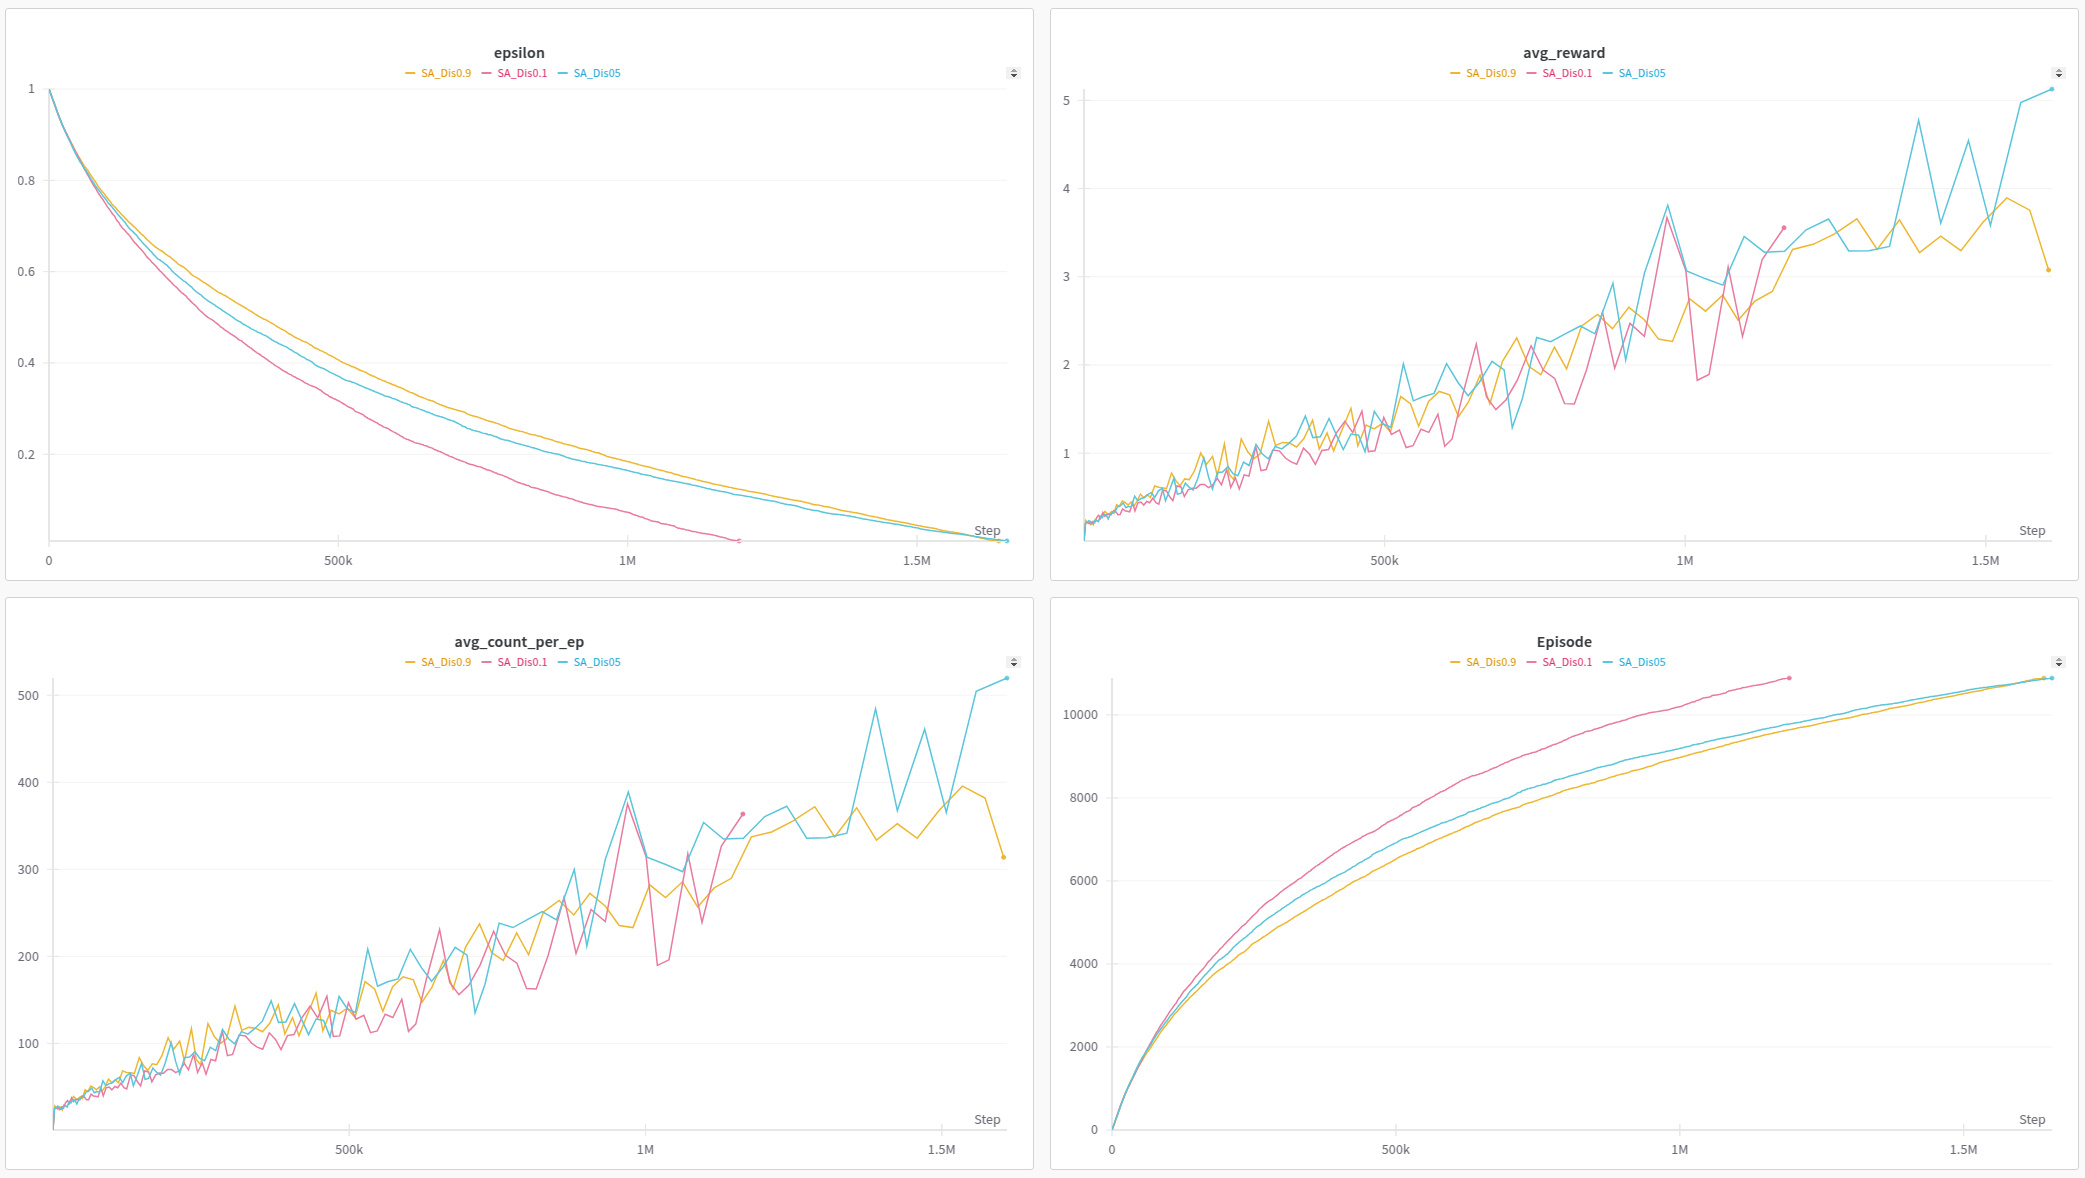

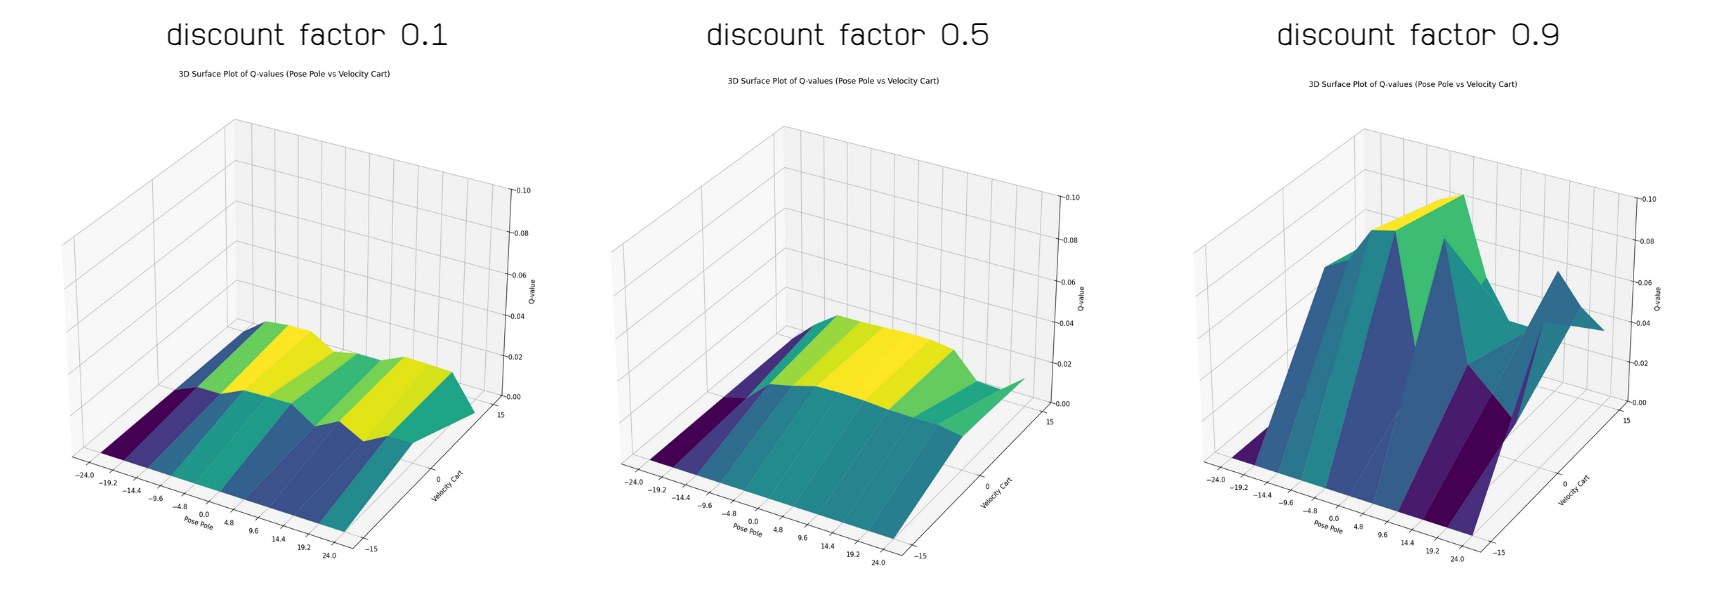


**Q-learning**

เทียบกราฟ discount factor 0.1 0.5 0.9 (เส้นสี ชมพู ฟ้า เหลือง ตามลำดับ)

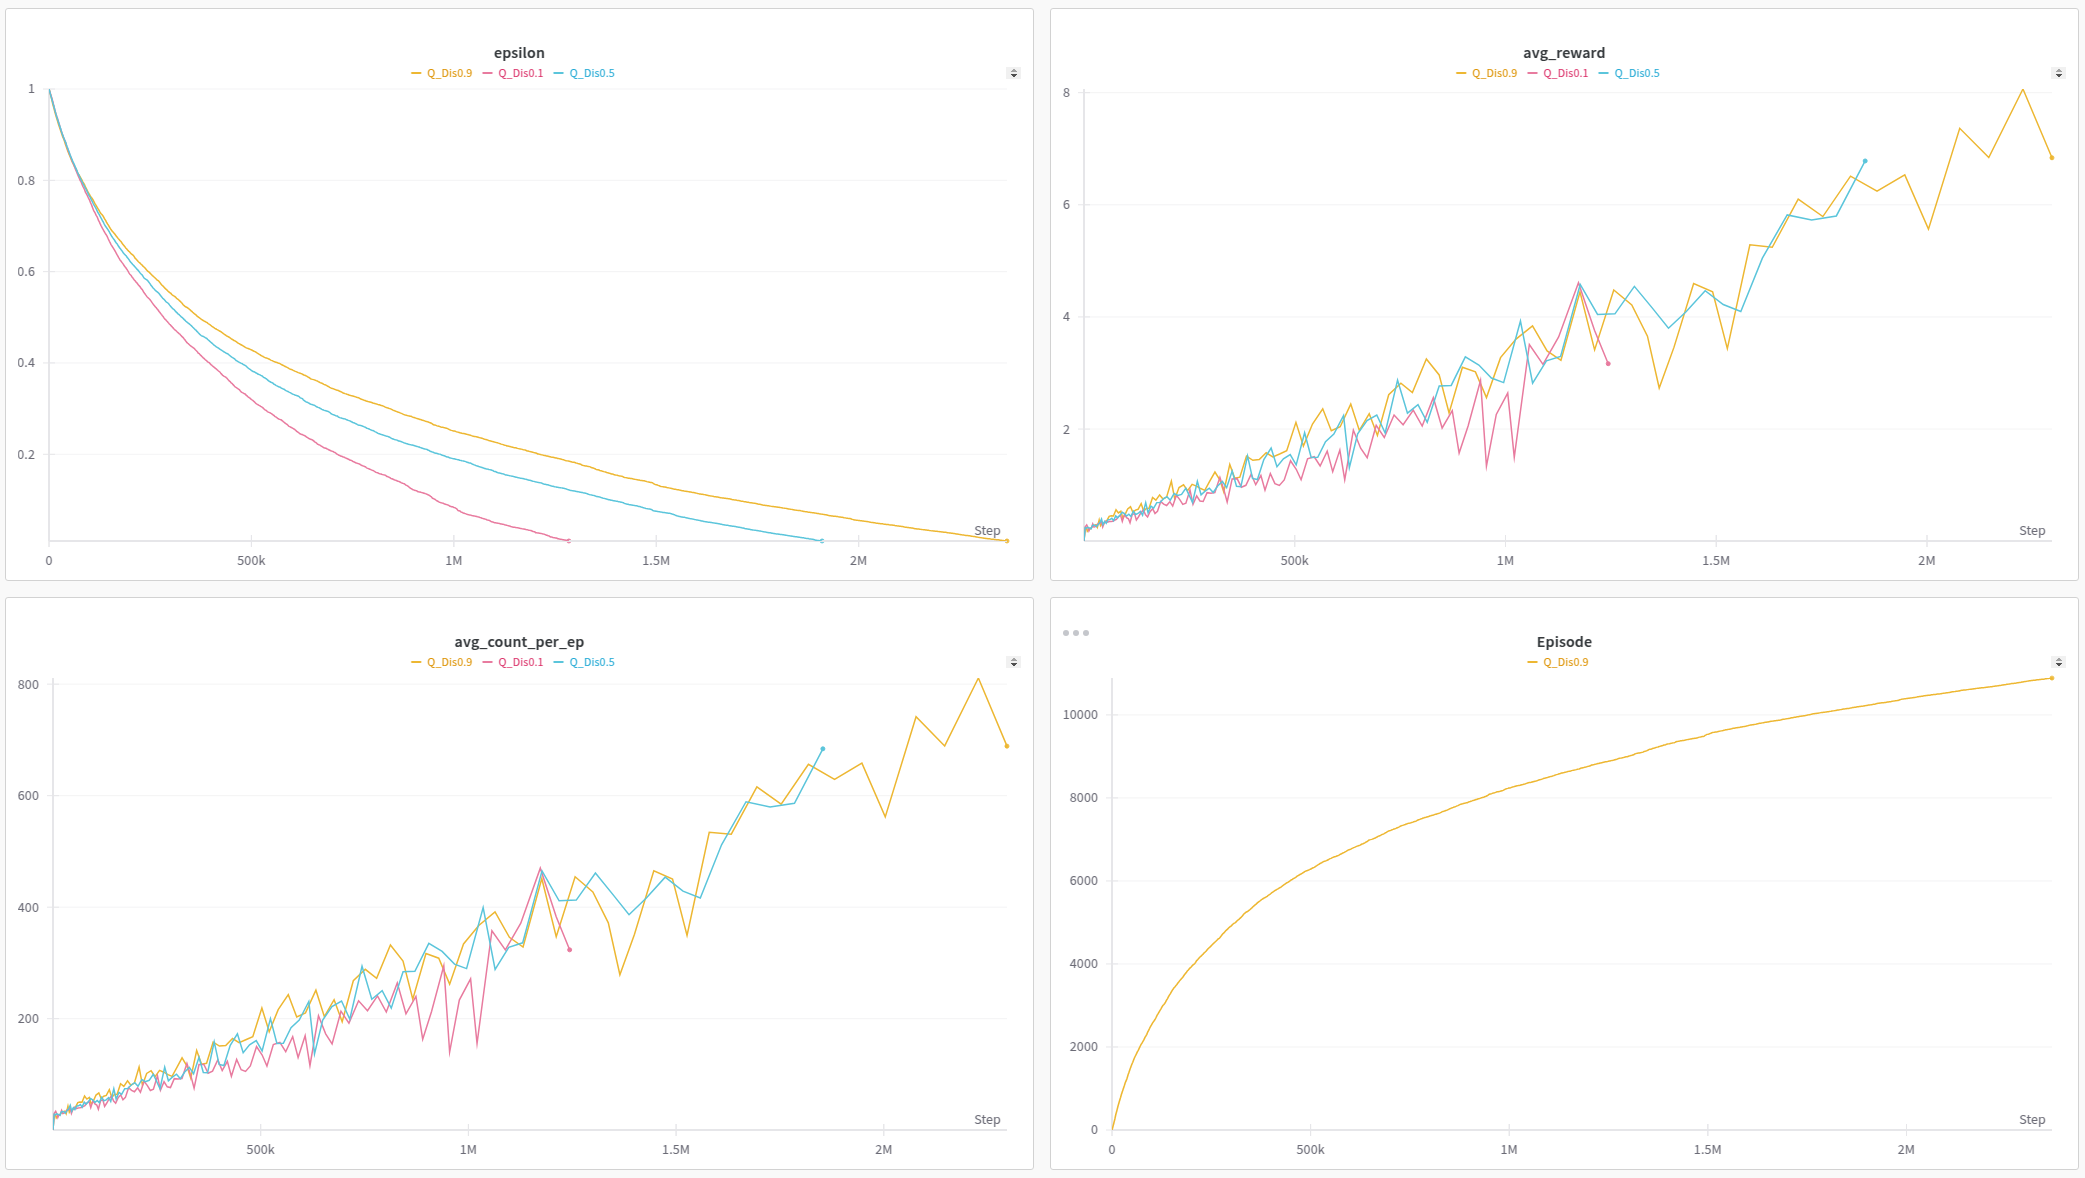

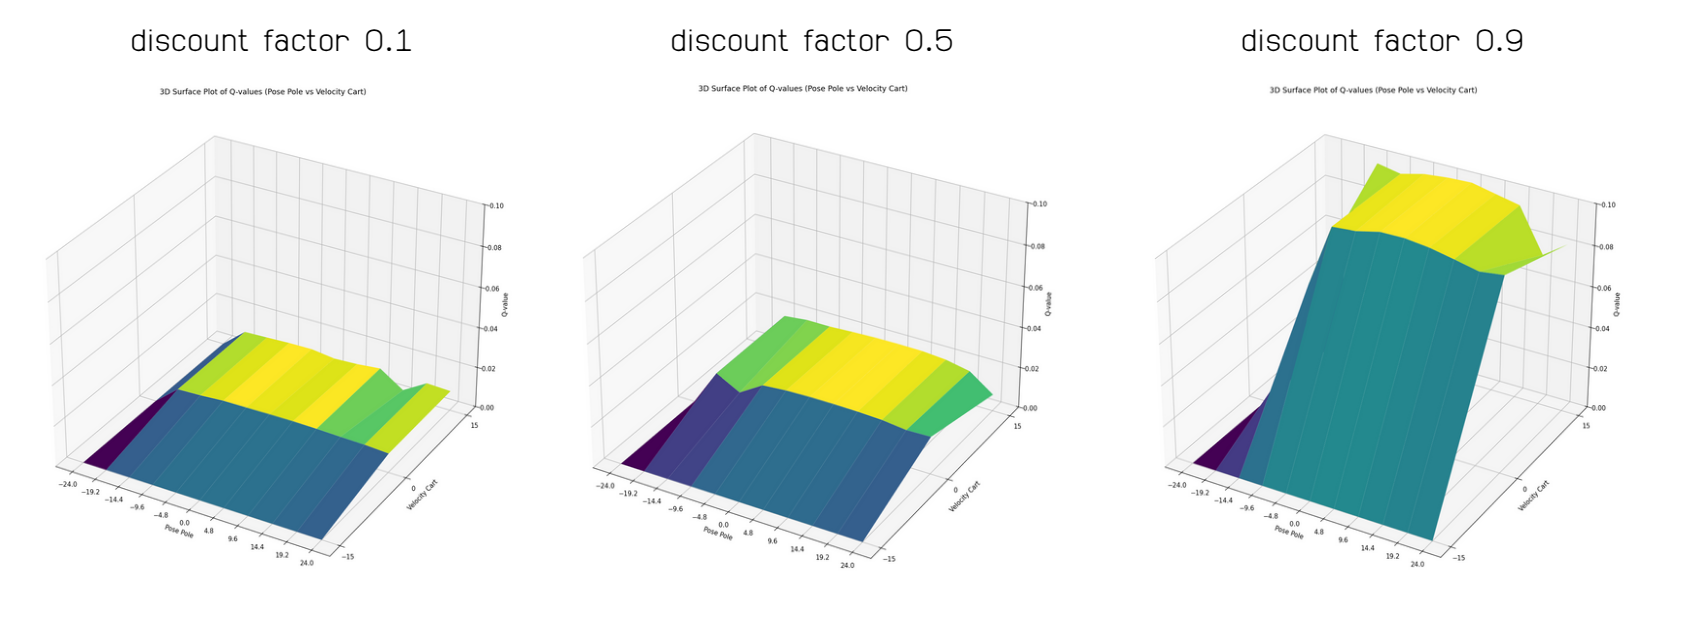

**Double Q learning**

เทียบกราฟ discount factor 0.1 0.5 0.9 (เส้นสี ชมพู ฟ้า เหลือง ตามลำดับ)

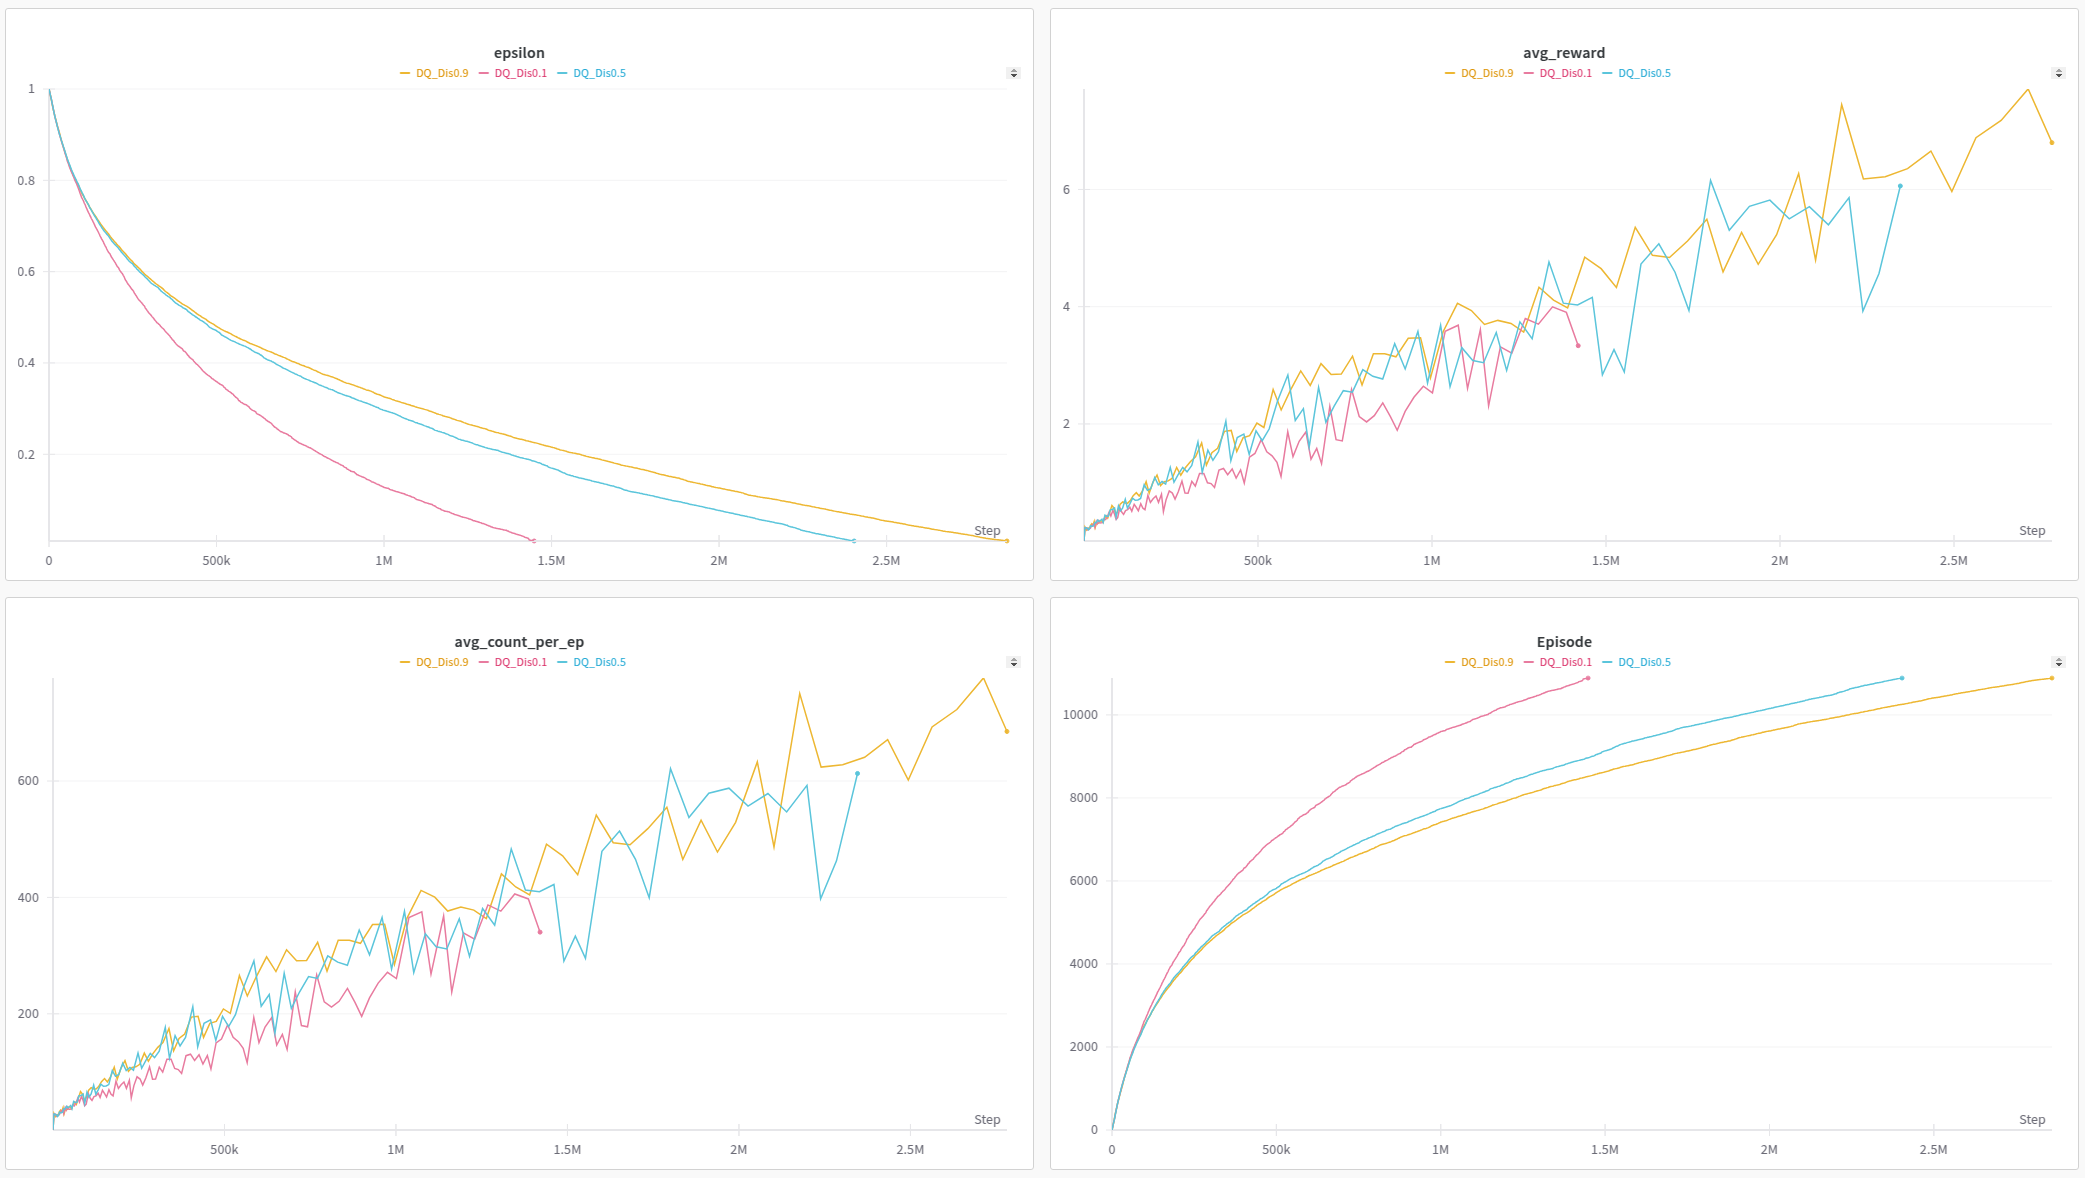


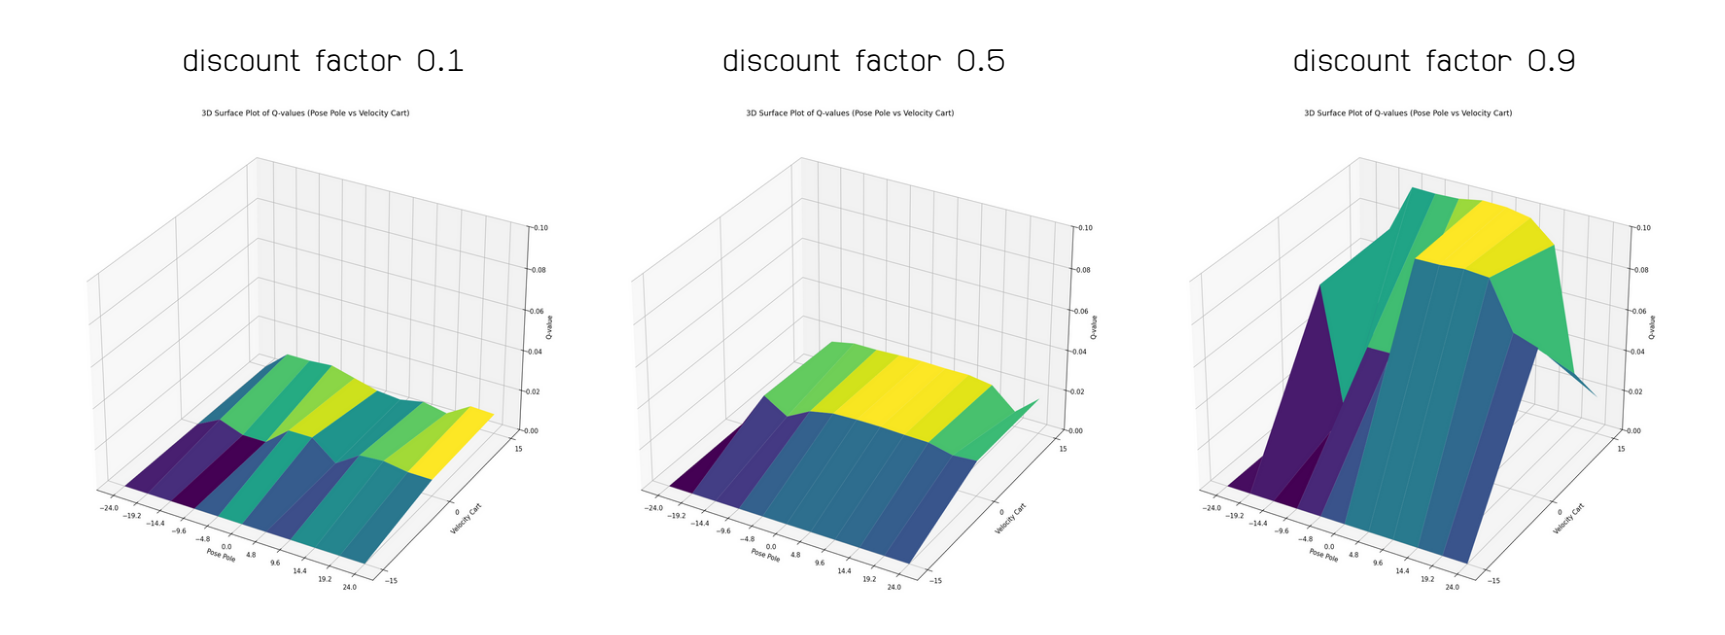

**ข้อสังเกตุจากการทดลองเทรนบนกราฟ 3D (Pose Pole VS Velocity Cart VS Q-Value)**

จากกราฟทั้งหมดที่แสดงมานั้นจะเห็นได้ว่าในแกนของ Velocity Cart นั้น ที่ทำการ Discretize State เป็น 3 นั้น ช่วงที่ต่ำกว่า 0 นั้น Agent นั้นไม่ค่อยมีการ Explore เท่าที่ควรจึงทำให้ Agent นั้นไม่สามารถแก้สถานการณืได้เมื่อไหลไปทางซ้ายของราง ซึ่งสอดคล้องกับในคลิปด้านล่าง แต่ถ้าไหลไปทางขวา Agent จะสามารถเลี้ยงตัวเองให้กลับมาตรงกลางได้ ซึ่งเป็นแบบนี้ในทุกการทดลองเลย

In [5]:
video_path = 'videos\Left defect - Made with Clipchamp.mp4'

# HTML code to embed the video
HTML(f"""
<video width="640" height="480" controls>
  <source src="{video_path}" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

<>:1: SyntaxWarning: invalid escape sequence '\L'
<>:1: SyntaxWarning: invalid escape sequence '\L'
C:\Users\anawa\AppData\Local\Temp\ipykernel_42088\3561936154.py:1: SyntaxWarning: invalid escape sequence '\L'
  video_path = 'videos\Left defect - Made with Clipchamp.mp4'


#### 2.2.ทำลองปรับ hyperparameters ในสภาพแวดล้อมที่มี state และ action space แบบ continuous 

**Learning Objective**

Explore approaches to implementing reinforcement learning in real-world scenarios where the state and action spaces are continuous.

**hyperparameters ที่จะปรับ**
1. num_of_action : 3 5 11 
2. discretize_state_weight 
    - เช็ค pose_cart : [11,1,1,1]
    - เช็ค pose_pole : [1,11,1,1]
    - เช็ค vel_cart  : [1,1,11,1]
    - เช็ค vel_pole  : [1,1,1,11]
    - เอา 2 ค่าที่ดีที่สุดมารวมกัน 


**ตัวแปรควบคุม**

ใช้ **Q-learning** (เลือกค่าตัวแปรควบคุมจาก best value ของการทดลองที่ 1)

- learning_rate = 0.1

- action_range = [-16.0, 16.0]

- discount = 0.9

- n_episodes = num_of_action * discretize_state_weight[0] * discretize_state_weight[1] * discretize_state_weight[2] * discretize_state_weight[3]*2 

**episodes เปลี่ยนไปตาม discretize_state กับ num_of_action

##### 1. Num of action

เทียบกราฟ num_of_action 3 5 11 (เส้นสี แดง ม่วง เทา ตามลำดับ)

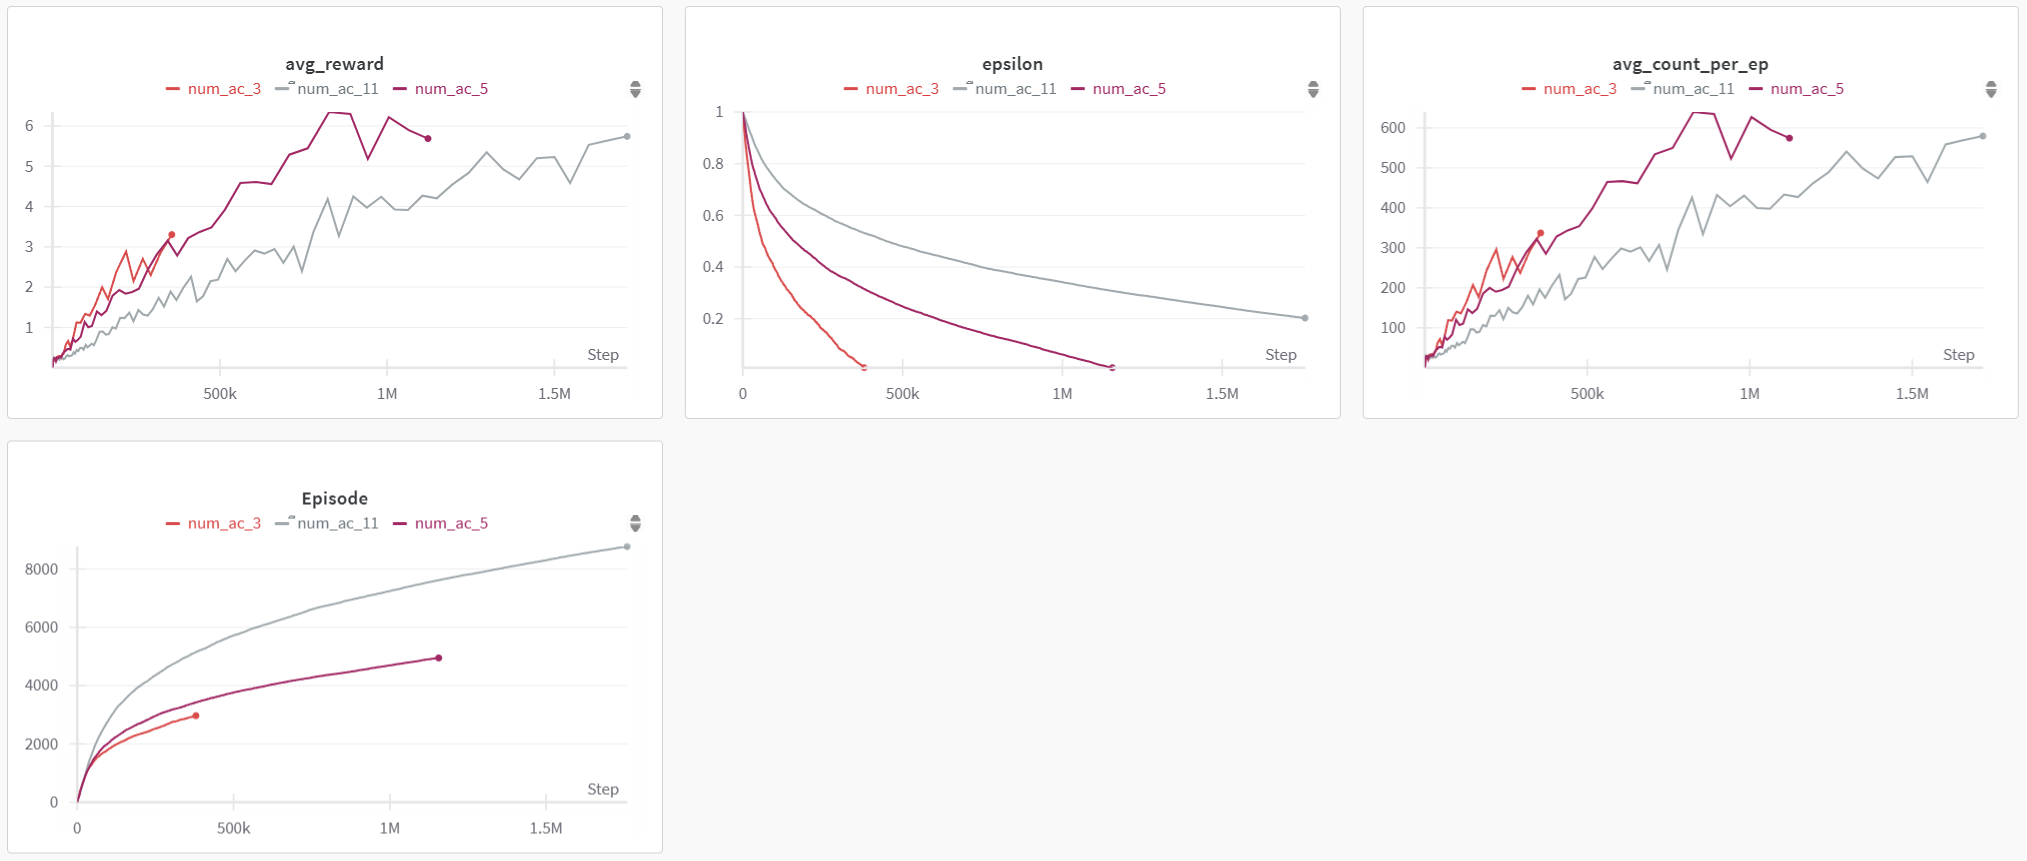

##### 2. discretize_state_weight

**Experiment 1 : กราฟเทียบ weight แบบต่างๆ** 

- weight เน้น pose_cart : [11,1,1,1]  กราฟสีชมพู

- weight เน้น pose_pole : [1,11,1,1]  กราฟสีฟ้า

- weight เน้น vel_cart  : [1,1,11,1]  กราฟสีเหลือง

- weight เน้น vel_pole  : [1,1,1,11]  กราฟสีเขียว

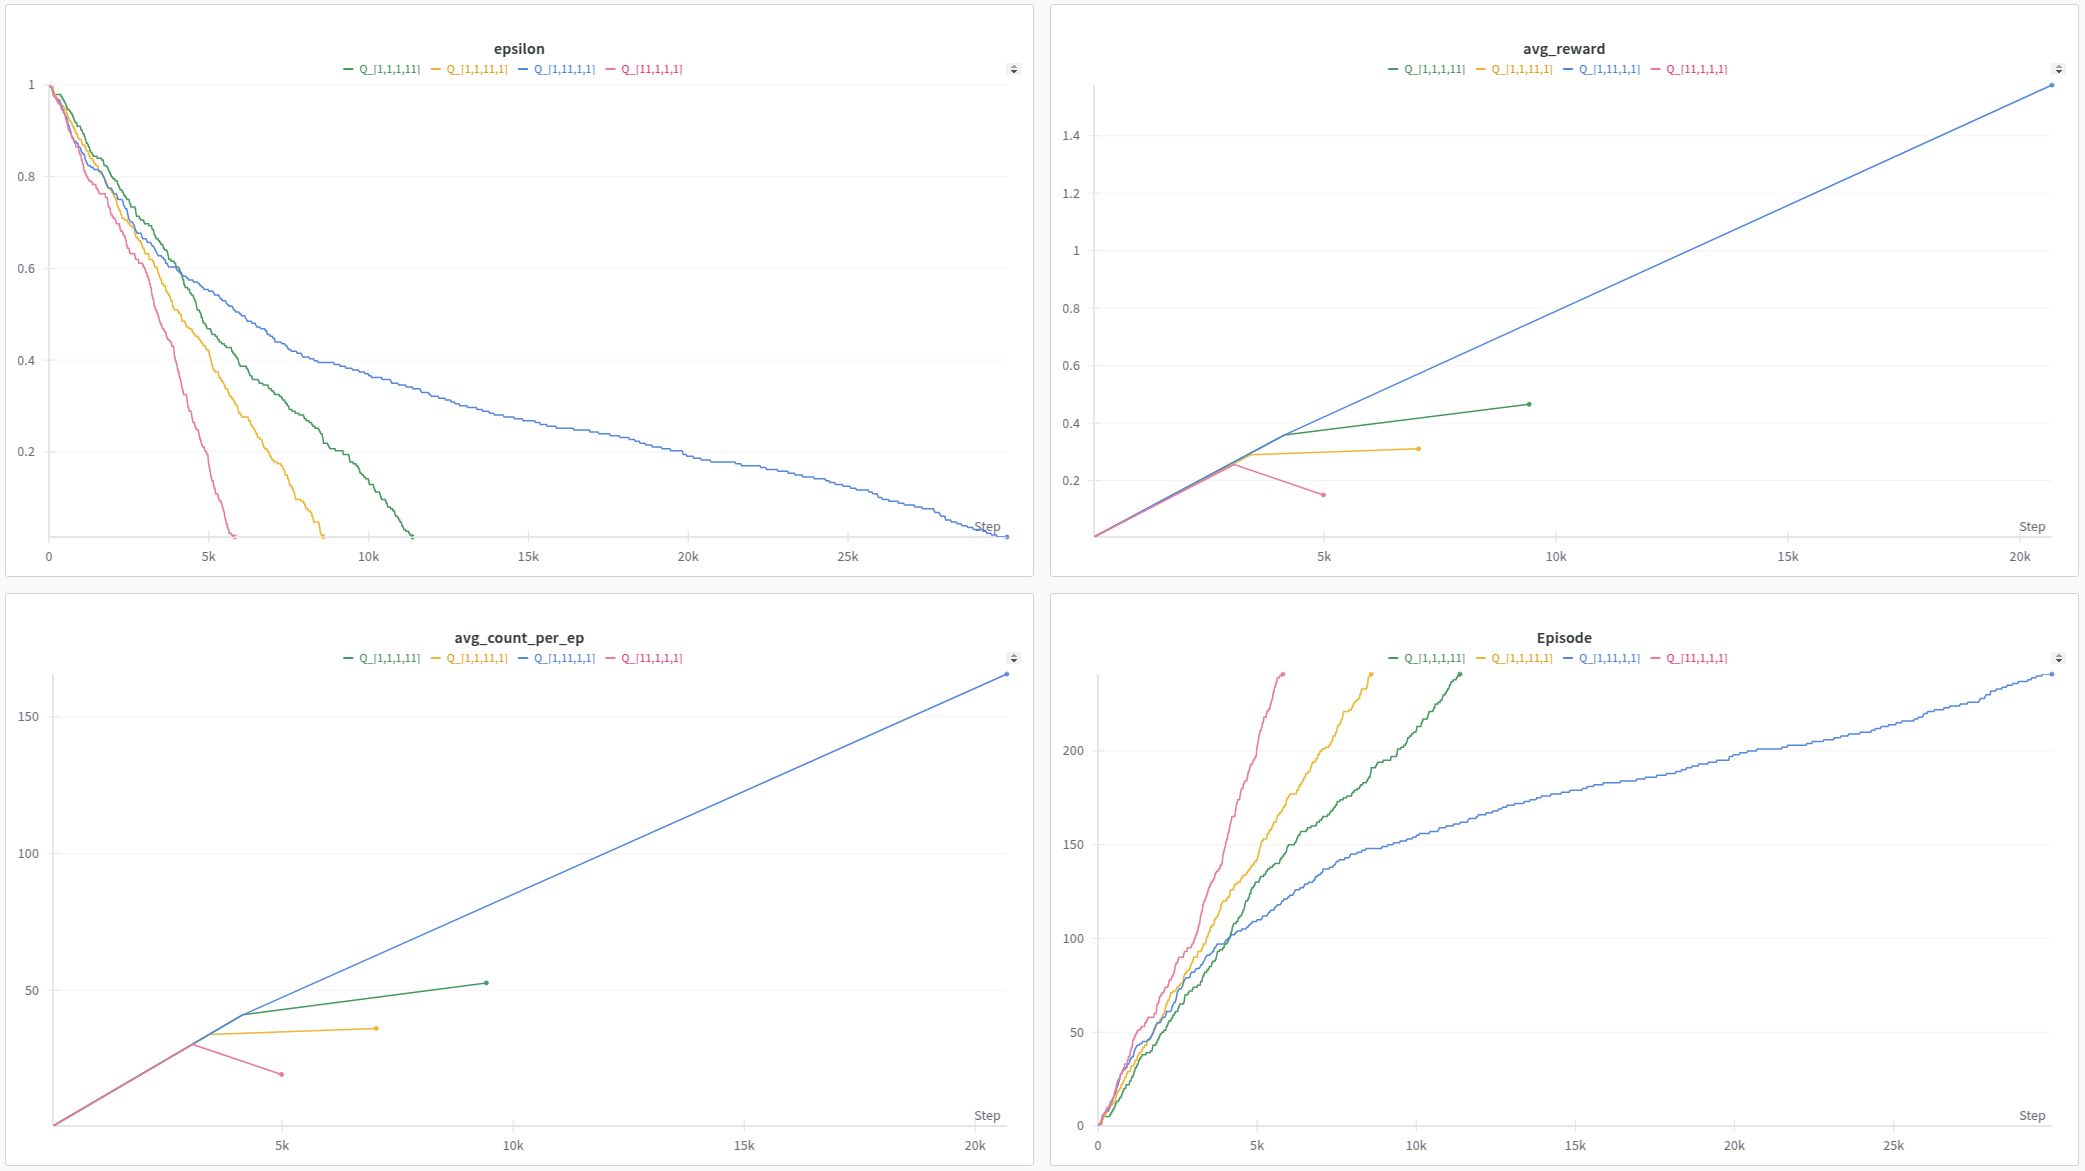

**สรุปผลการทดลอง**

1. น้ำหนักที่เน้น pose_pole ([1,11,1,1]) – กราฟสีฟ้า เป็นเพียงชุดเดียวที่สามารถ เรียนรู้ต่อเนื่องได้นานที่สุด
    - avg_reward, avg_count_per_ep, และ Episode เพิ่มขึ้นอย่างต่อเนื่องและชัดเจน

    - epsilon ลดช้า >> มีการ explore นานกว่า >> ช่วยค้นหา policy ที่ดีกว่า

- **สรุป** >> การแบ่งช่วงละเอียดในมุมของเสา (pose_pole) มีผลสำคัญต่อความสามารถของ agent ในการรักษาเสถียรภาพของ CartPole

2. น้ำหนักที่เน้น vel_pole ([1,1,1,11]) – กราฟสีเขียว มีการเรียนรู้ได้ดีในช่วงแรก

    - avg_reward เพิ่มขึ้นเรื่อย ๆ แต่หยุดก่อนจะไปถึงขั้นที่ agent คงเสถียร

    - epsilon ลดลงเร็ว >> หยุด explore ไว >> อาจเรียนรู้ไม่ครอบคลุม

- **สรุป** >> การให้ความสำคัญกับ angular velocity (vel_pole) ช่วยบ้าง แต่ยังไม่เท่า pose_pole

3. น้ำหนักที่เน้น vel_cart ([1,1,11,1]) – กราฟสีเหลือง เรียนรู้ได้เร็วในช่วงแรก แต่หยุดเร็ว

    - avg_reward ต่ำกว่ากรณีอื่น

    - epsilon ลดไวมาก >> การสำรวจไม่เพียงพอ

- **สรุป** >> ความเร็วของรถเข็น (vel_cart) ไม่ได้ช่วยมากในการควบคุมสมดุล

4. น้ำหนักที่เน้น pose_cart ([11,1,1,1]) – กราฟสีชมพู เรียนรู้เร็วที่สุด (epsilon ลดเร็วมาก)

    - แต่ avg_reward ค่อนข้างต่ำ และหยุดเรียนรู้ไว

- **สรุป** >> การเน้นแค่ตำแหน่งรถเข็นอย่างเดียวไม่เพียงพอในการควบคุมเสาให้ตั้งตรง

**Experiment2 : discretize_state_weight เอา 2 ค่าที่ดีที่สุดมารวมกัน**

**weight เน้น pose_pole และ  vel_pole**

- [1,11,1,11] กราฟสีชมพู
- [1,17,1,11] กราฟสีฟ้า
- [3,11,1,7]  กราฟสีเหลือง

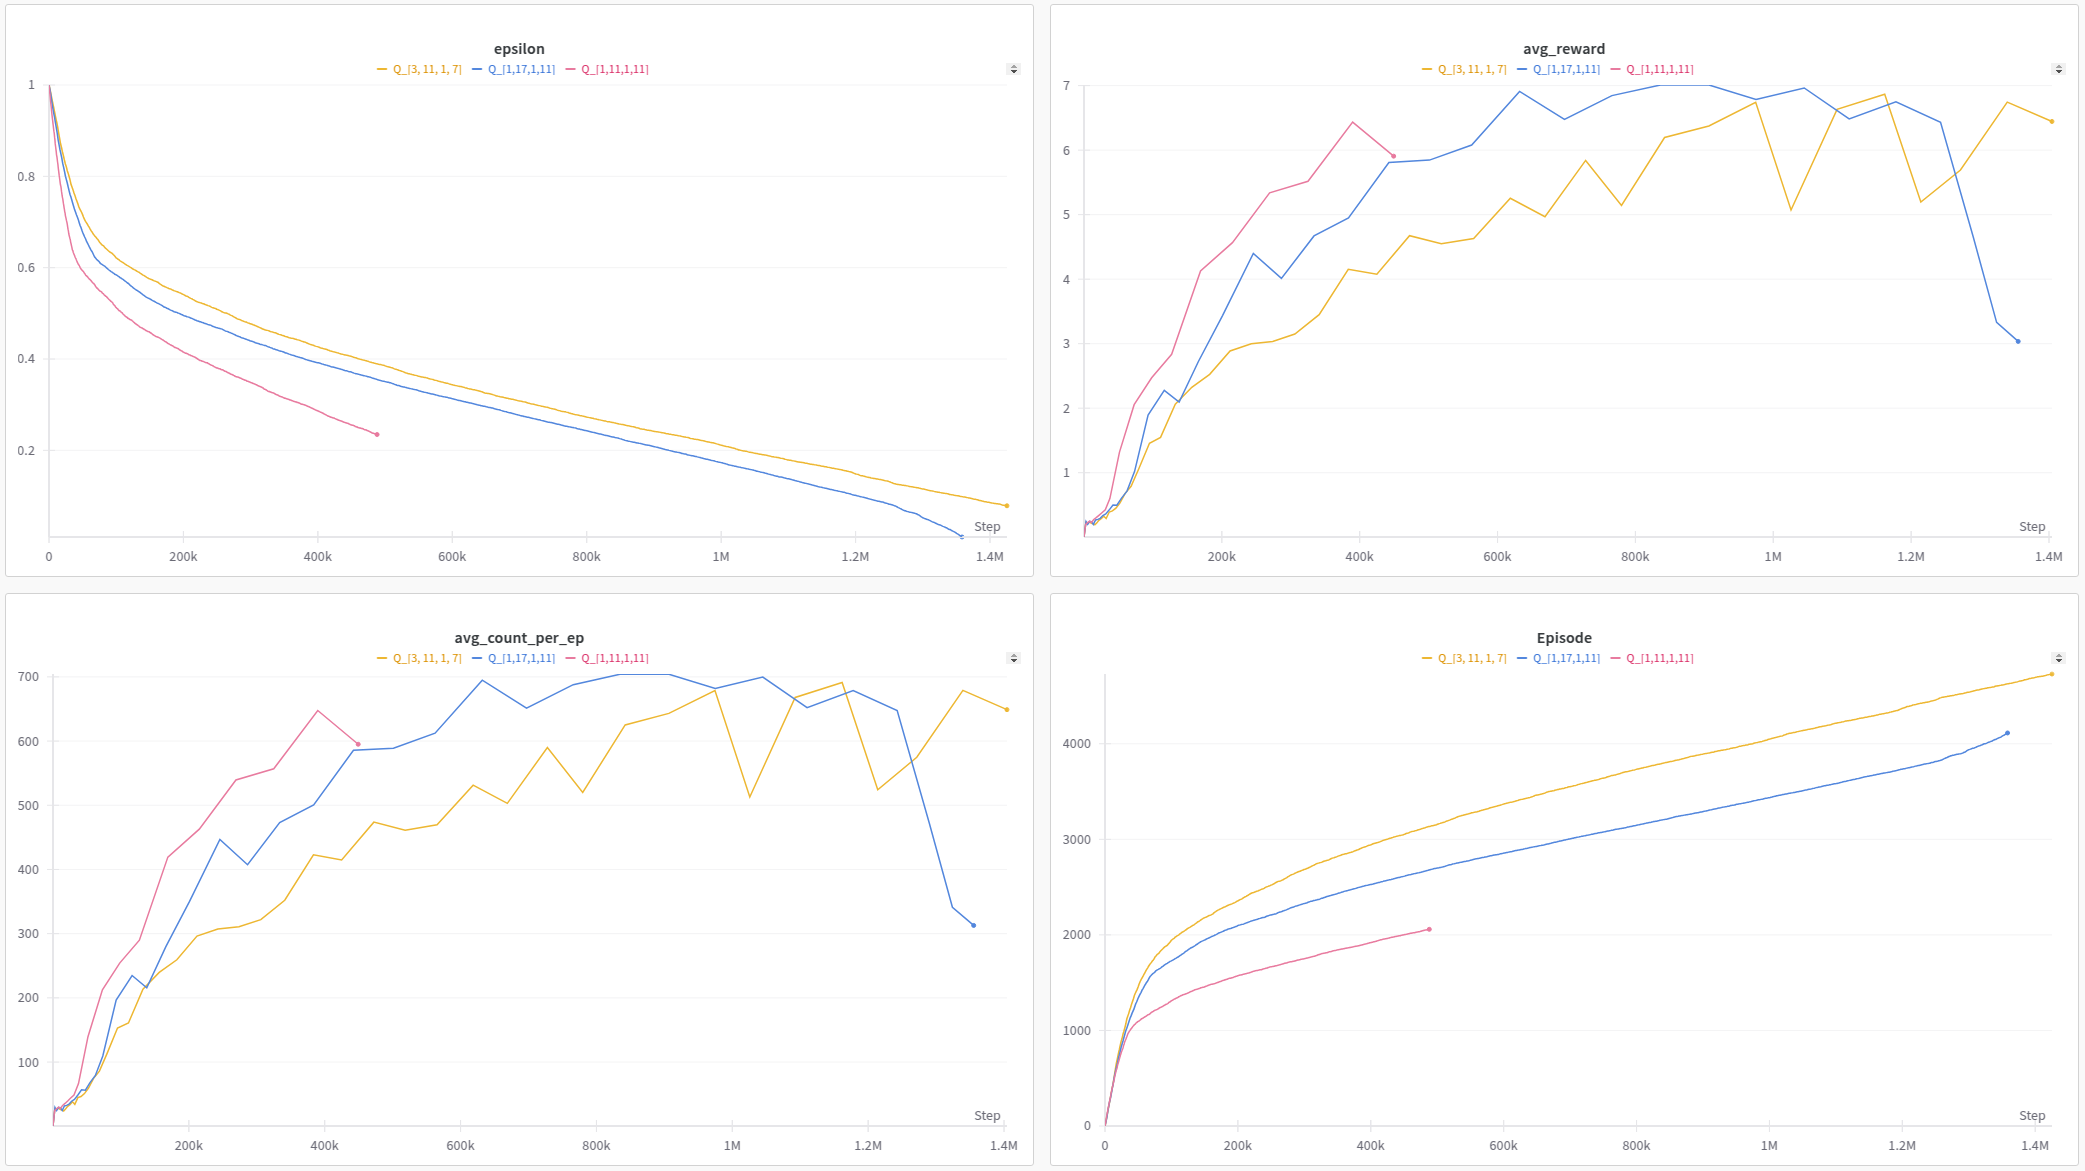

**สรุปผลการทดลอง**

1. [1,11,1,11] (กราฟสีชมพู)

    - เรียนรู้เร็วที่สุดในช่วงต้น: เห็นได้จาก avg_reward และ avg_count_per_ep ที่พุ่งสูงในช่วง 400k step แรก

    - epsilon ลดเร็ว >> หยุด explore เร็ว >> อาจไม่เจอ policy ที่ดีกว่านี้ในช่วงหลัง

    - สุดท้าย performance คงที่ แต่ไม่สูงสุด

- **สรุป** >> เป็น balance ที่ดีในช่วงต้น แต่ยังไม่เพียงพอต่อการรักษาประสิทธิภาพในระยะยาว

2. [1,17,1,11] (กราฟสีฟ้า)

    - ค่า reward เฉลี่ยสูงที่สุด เกือบตลอดช่วงกลาง (600k–1.2M)

    - avg_count_per_ep สูง >> agent อยู่ได้นาน

    - แต่ performance ตกลงอย่างชัดเจนช่วงท้าย >> อาจเกิดจาก overfitting หรือหยุด explore ช้าเกินไป

- **สรุป** >> การให้ weight มากเกินไปกับ pose_pole ทำให้เรียนรู้ช้าในช่วงแรก แต่ได้ผลดีในช่วงกลาง ก่อนจะเริ่มเสื่อมลง

3. [3,11,1,7] (กราฟสีเหลือง)

    - ค่า reward และ episode เพิ่มขึ้น สม่ำเสมอและต่อเนื่อง

    - epsilon ลดช้าที่สุด >> สำรวจได้นาน >> มีแนวโน้มจะพัฒนาได้อีก

    - แม้ค่า avg_reward ยังไม่พีคที่สุด แต่ เสถียรกว่า ตัวอื่นในช่วงยาว

- **สรุป**>> อัตราสำรวจที่นานกว่า + weight ที่เหมาะสม ทำให้เรียนรู้อย่างต่อเนื่องและมีแนวโน้มพัฒนาได้อีกในอนาคต



**เทียบกับกราฟของการทดลองที่ 1 ที่มี weight ดังนี้ [5,11,3,3]**

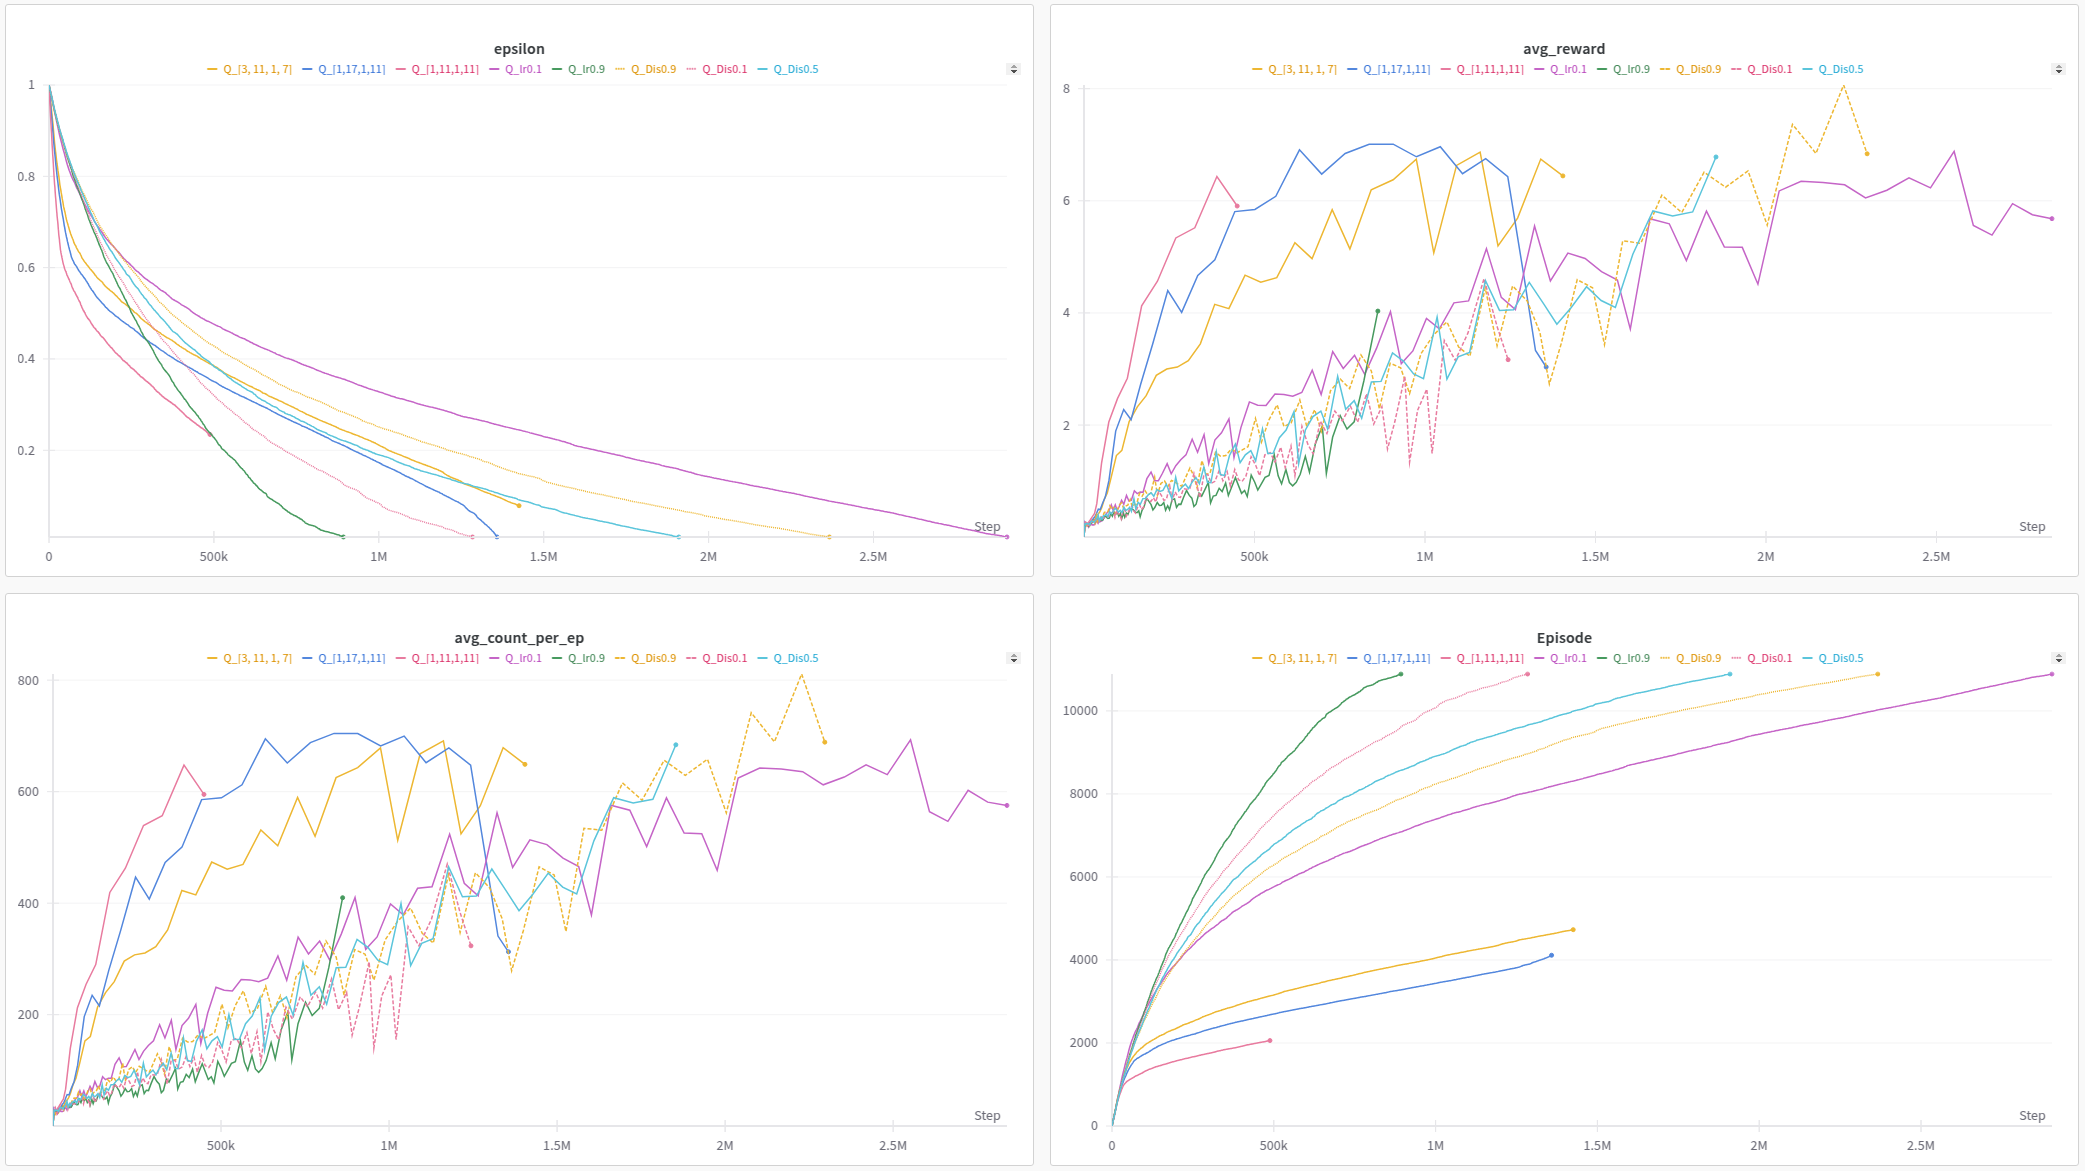



### 3. Implement main() in play script (in the "Can be modified")

#### 3.1. hyperparameters tuning

In [ ]:
# hyperparameters
num_of_action = 11
action_range = [-16.0 , 16.0] 
discretize_state_weight = [5, 11, 3, 3]  
learning_rate = 0.3
n_episodes = 10000
start_epsilon = 0
epsilon_decay = 0 
final_epsilon = 0
discount = 0.50

ใช้ hyperparameters เดียวกันกับโค้ด Train

#### 3.2. Select Json file

In [ ]:
# 1.ดึงชื่อ task (เช่น "Stabilize") จาก argument
task_name = str(args_cli.task).split('-')[0]
# 2.กำหนดชื่ออัลกอริธึมที่ใช้
Algorithm_name = "Q_Learning"  
# 3.สร้างชื่อไฟล์ .json สำหรับโหลด Q-table ที่ฝึกไว้
q_value_file = f"{Algorithm_name}_{n_episodes}_{num_of_action}_{action_range[1]}_{discretize_state_weight[0]}_{discretize_state_weight[1]}_{discount}_{learning_rate}.json"
# 4.แสดงชื่อไฟล์เพื่อเช็กความถูกต้อง
print(q_value_file)
# 5.สร้าง path ที่อยู่ของไฟล์ Q-table และโหลดเข้า agent
full_path = os.path.join(f"q_value/{task_name}", Algorithm_name)
agent.load_model(full_path, q_value_file)


โค้ดนี้ใช้เตรียมข้อมูลสำหรับโหลดโมเดล Q-values ที่ฝึกไว้แล้ว โดยเริ่มจากการดึงชื่อ task เช่น "Stabilize" จาก arguments ที่รับเข้ามา จากนั้นกำหนดชื่อของอัลกอริธึมที่ใช้งาน เช่น "Q_Learning" แล้วนำค่าพารามิเตอร์ต่าง ๆ มาประกอบเป็นชื่อไฟล์ .json ที่เก็บ Q-table ซึ่งเคยถูกบันทึกไว้หลังจากการฝึกฝน ก่อนจะนำ path ที่อยู่ของไฟล์นั้นมารวมกับชื่อไฟล์ และสุดท้ายใช้คำสั่ง load_model() เพื่อโหลด Q-values เข้ามาให้ agent ใช้สำหรับการเล่นใน phase ทดสอบหรือการ deploy โดยไม่ต้องฝึกใหม่อีกครั้ง

#### 3.3. Play Loop

In [ ]:
# 1. เริ่มต้นรีเซ็ต environment
obs, _ = env.reset()
timestep = 0
# 2. เริ่มลูปจำลอง environment (เล่นไปเรื่อยๆ ตราบใดที่ยังเปิด simulation อยู่)
while simulation_app.is_running():
    # 3. ปิดการ track gradient ของ PyTorch เพื่อเพิ่มความเร็ว (เพราะไม่ได้ฝึกโมเดล)
    with torch.inference_mode():
        # 4. วนเล่น environment ตามจำนวน episode ที่กำหนด
        for episode in range(n_episodes):
            # 4.1 รีเซ็ต environment ใหม่สำหรับแต่ละ episode
            obs, _ = env.reset()
            done = False
            # 4.2 เริ่มลูปการเล่นในแต่ละ episode
            while not done:
                # 4.2.1 ให้ agent เลือก action จาก observation ปัจจุบัน
                action, action_idx = agent.get_action(obs)
                # 4.2.2 ส่ง action เข้า environment และรับผลลัพธ์กลับมา
                next_obs, reward, terminated, truncated, _ = env.step(action)
                # 4.2.3 ตรวจสอบว่าสิ้นสุด episode หรือยัง (เช่น cartpole ล้ม)
                done = terminated or truncated
                # 4.2.4 อัปเดต observation สำหรับ timestep ถัดไป
                obs = next_obs
    # 5. ถ้ามีการระบุให้บันทึกวิดีโอ (เช่น --video), บันทึก timestep
    if args_cli.video:
        timestep += 1
        if timestep == args_cli.video_length:
            break



- agent ใช้ policy (get_action) ที่ฝึกไว้แล้ว

- ส่ง action ให้ environment

- รับ reward และสถานะใหม่ (next_obs)

- วนจนกว่าจะจบ episode (pole ล้ม หรือ agent หยุด)

#### 3.4. Experiment 

**Objective**
1. ทดลองปรับ Parameter เพื่อหาว่าค่า Parameter แบบใดทำให้สามารถดึง state action pair  ที่ต้องการมาใช้ได้

**Assumtion**
1. ค่า Epsilon มีผลต่อการ Explore และ Exploit ของ Agent 
2. ปรับ Epsilon ให้เท่ากับ 0 Agent จะเลือก Exploit เสมอ

**Experiment 1** : ลองปรับ Hyperparameter เหมือนโค้ด Train ทั้งหมด

In [ ]:
# hyperparameters
num_of_action = 11
action_range = [-16.0 , 16.0] 
discretize_state_weight = [5, 11, 3, 3]  
learning_rate = 0.3
n_episodes = 10000
start_epsilon = 1       #epsilon
epsilon_decay = 0.997   #epsilon
final_epsilon = 0.01    #epsilon
discount = 0.50

##### ผลลัพท์จากการ Run Play

In [ ]:
video_path = 'videos\epsilon n - Made with Clipchamp.mp4'

# HTML code to embed the video
HTML(f"""
<video width="640" height="480" controls>
  <source src="{video_path}" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

<>:1: SyntaxWarning: invalid escape sequence '\e'
<>:1: SyntaxWarning: invalid escape sequence '\e'
C:\Users\anawa\AppData\Local\Temp\ipykernel_42088\3663099105.py:1: SyntaxWarning: invalid escape sequence '\e'
  video_path = 'videos\epsilon n - Made with Clipchamp.mp4'


**สรุปผลการทดลองที่ 1** 

Agent จะมีโอกาส "สุ่ม" เลือก action แทนที่จะเลือกจาก Q-table เสมอไปโดยเช่น

ถ้า epsilon = 0.8 → หมายความว่า
- 80% agent จะ "สุ่ม" action จาก action space
- 20% agent จะ "เลือก action ที่ดีที่สุด" จาก Q-table ที่โหลดมา

**Experiment 2** : ลองปรับ Hyperparameter Epsilon ให้เป็น 0 ทั้งหมด

In [ ]:
# hyperparameters
num_of_action = 11
action_range = [-16.0 , 16.0] 
discretize_state_weight = [5, 11, 3, 3]  
learning_rate = 0.3
n_episodes = 10000
start_epsilon = 0  #epsilon
epsilon_decay = 0  #epsilon
final_epsilon = 0  #epsilon
discount = 0.50

##### ผลลัพท์จากการ Run Play

In [3]:
video_path = 'videos\epsilon 0 - Made with Clipchamp.mp4'

# HTML code to embed the video
HTML(f"""
<video width="640" height="480" controls>
  <source src="{video_path}" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

<>:1: SyntaxWarning: invalid escape sequence '\e'
<>:1: SyntaxWarning: invalid escape sequence '\e'
C:\Users\anawa\AppData\Local\Temp\ipykernel_42088\1832368421.py:1: SyntaxWarning: invalid escape sequence '\e'
  video_path = 'videos\epsilon 0 - Made with Clipchamp.mp4'


**สรุปผลการทดลองที่ 2** 

Agent exploit ในทันที เพราะ Agent จะเลือก action ที่มี Q-value สูงสุด จาก Q-table ที่โหลดมาจากไฟล์ .json สำหรับ state ปัจจุบัน
เพราะ epsilon = 0 → ไม่มีการสุ่ม ทุกการตัดสินใจมาจาก ค่าใน Q-table เท่านั้น

**Summary**

**epsilon > 0** → ใช้ในช่วง ฝึก (training)
เพื่อให้ agent ลอง action ใหม่ ๆ ที่ยังไม่เคยทำมาก่อน เพิ่มโอกาสค้นพบวิธีที่ดีกว่า

**epsilon = 0** → ใช้ในช่วง เล่นจริง / ทดสอบ (play/deploy)
เพื่อให้ agent เลือกสิ่งที่ดีที่สุดเท่านั้น จากที่เคยเรียนรู้มาแล้ว

## Part 3: Evaluate Cart-Pole Agent performance

### Which algorithm performs best, How it perform better than the others?
- จากการทดลองพบว่า Q-Learning  และ Double-Q-Learning สามารถเรียนรู้ได้ Reward สูงที่สุดในบรรดา 4 Agents นี้ แต่ในส่วนของ Q-Learning จะสามารถเรียนรู้ได้ถึง Reward สูงสุดเร็วกว่า Double-Q-Learning ซึ่งต้องใช้การ Explore และ Episode ที่มากพอต่อการสำรวจของ Agent แต่ได้ Reward มากกว่าเล็กน้อยใน Episode ที่เท่ากัน 

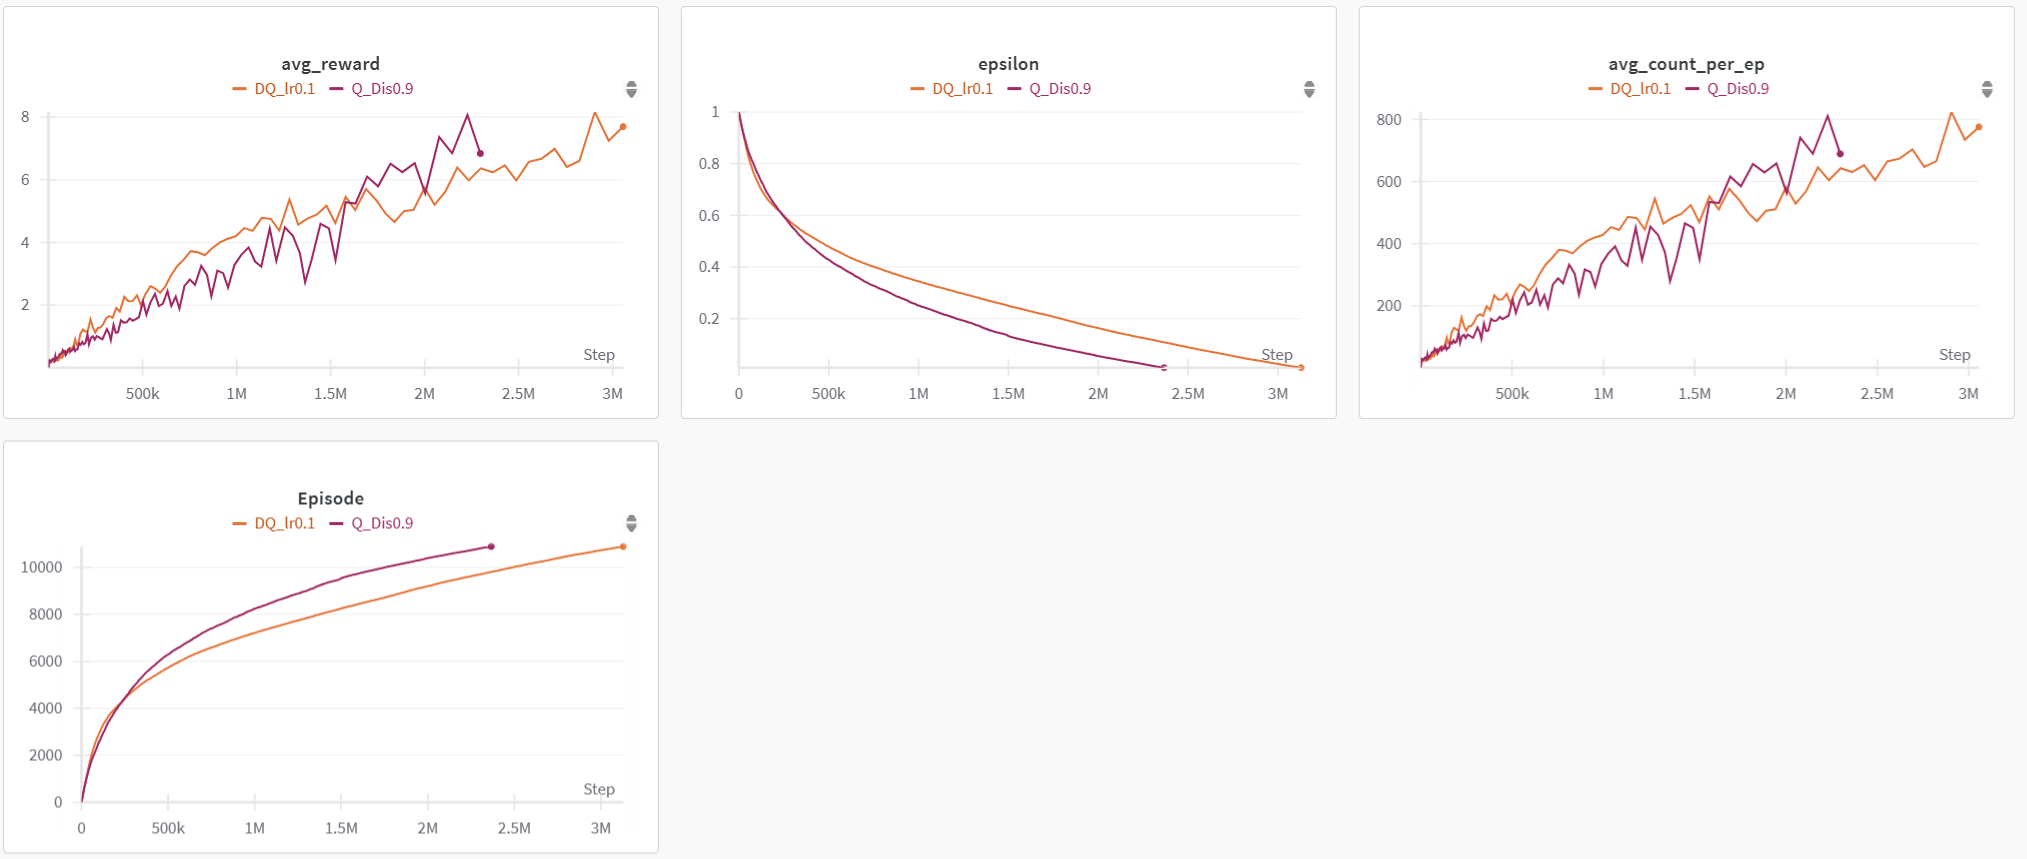


### How do the resolutions of the action space and observation space affect the learning process? Why?
ความละเอียดในการ Discretize Action และ State มีผลต่อการเรียนรู้ของ Agent

**Action**

การซอย State Action ให้ละเอียดขึ้นนั้นทำให้ agent สามารถมีความเป็นไปได้ที่จะเลือก Action ที่มีโอกาสจะบรรลุถึง Reward สูงสุดได้ดีมากยิ่งขึ้น ตามรูปด้านล่าง 

เทียบกราฟ num_of_action 3 5 11 (เส้นสี แดง ม่วง เทา ตามลำดับ)

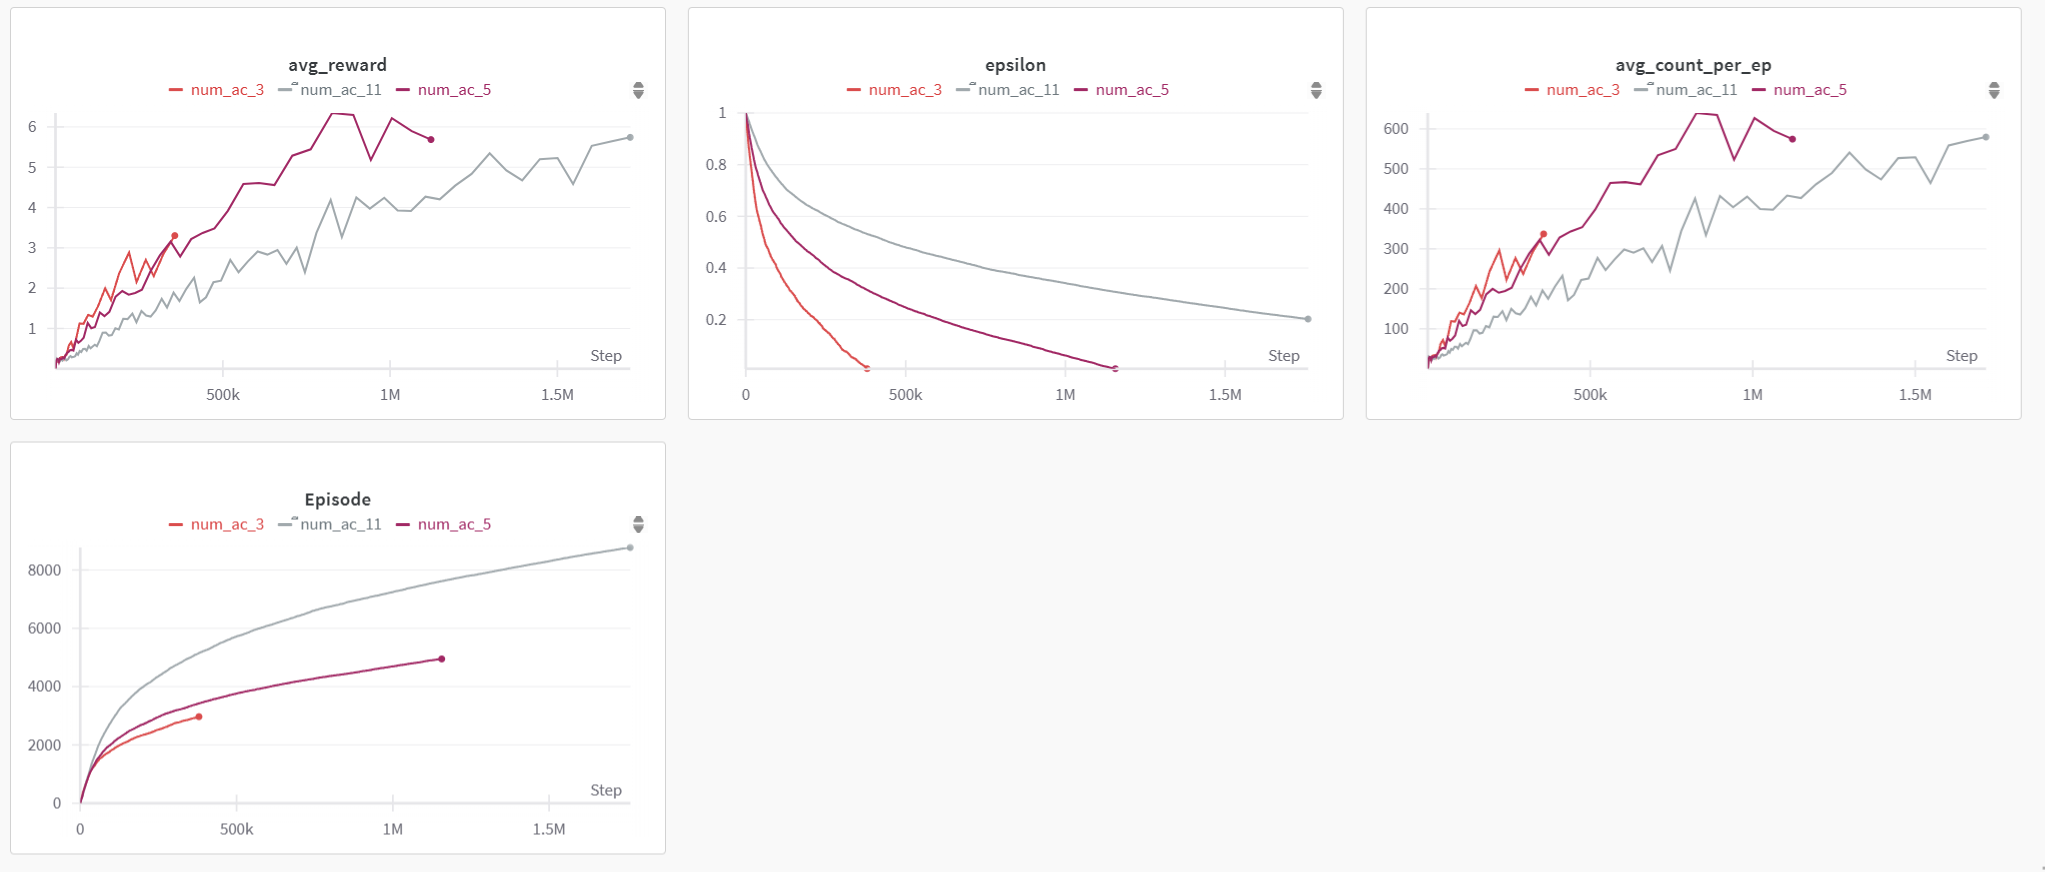



**Observation Space**

ในปัญหา Cartpole นั้นจริงๆแล้วเป็นแบบ Continuous แต่เราไม่สามารถที่จะเรียนรู้ทุกค่าที่อยู่ในช่วง Continuous ได้ เราจึงจำเป็นที่ต้องทำการ Discretize เพื่อให้ Agent ใช้เวลาเรียนรู้น้อยลง และถ้าสามารถให้ความสำคัญที่ถูกต้องกับ Observation ที่เกี่ยวข้องกับการทำงานจริงๆ ก็จะสามารถทำให้ Agent สามารถทำงานได้มีประสิทธภาพเช่นกัน ซึ่งในปัญหาการ Stabilize Pole นั้นการ Discretize Pose_Pole ออกมาเยอะๆ นั้นช่วยให้ Agent สามารถเรียนรู้ได้ดีอย่างเห็นได้ชัดเมื่อเทียบกับการให้ความสำคัญในการ Discretize Weight ตัวอื่นๆ ดังรูปด้านล่าง


- weight เน้น pose_cart : [11,1,1,1]  กราฟสีแดง

- weight เน้น pose_pole : [1,11,1,1]  กราฟสีเขียว

- weight เน้น vel_cart  : [1,1,11,1]  กราฟสีชมพู

- weight เน้น vel_pole  : [1,1,1,11]  กราฟสีส้ม

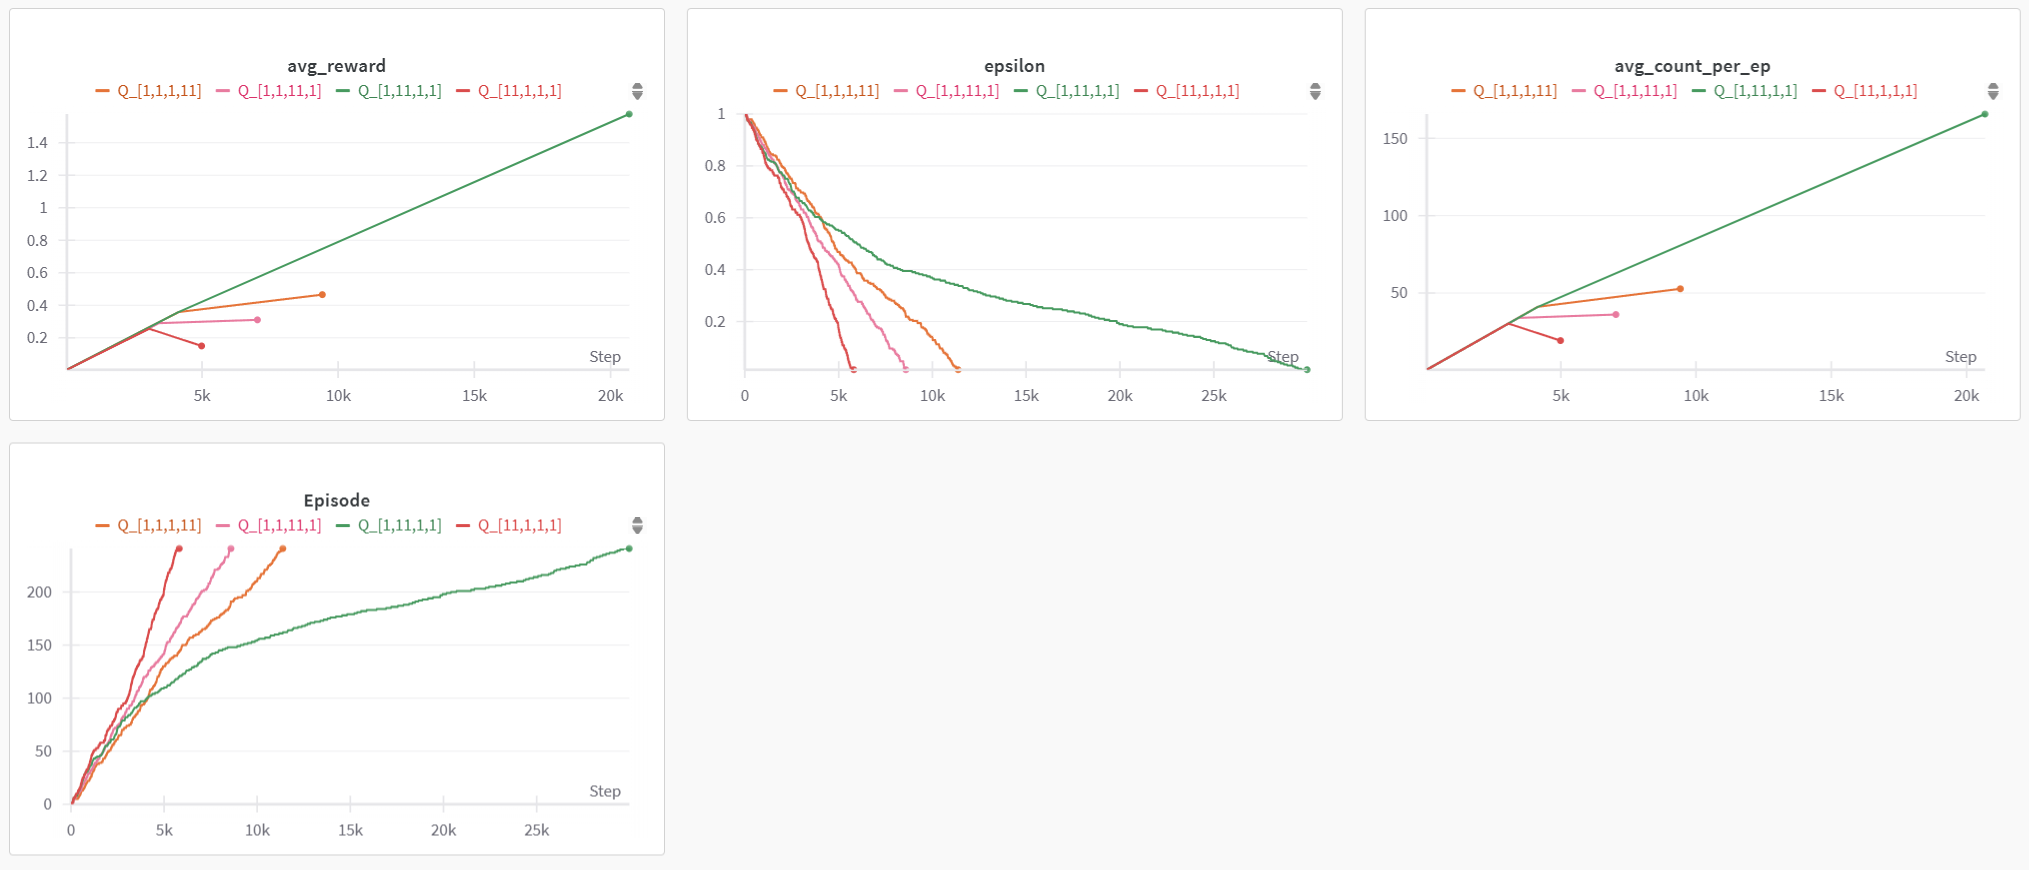